# Louvain methods and analysis

Cell below analyses the results in the Louvain index file using the sensitivity analysis methods from previous work

Overall results for Louvain version 3
Mean f-score for Louvain community detection for v1/v2 sigma across all results is 0.6385849909487242/0.49121414901366445
Mean f-score when only counting populations of similar individuals is 0.6385450458806562/0.6239939486810773


,v1f_score,v2f_score
log ratio,-0.56,-0.55
number of populations,-0.45,-0.36
expected noise:event ratio,-0.27,-0.19
number of time series compared,-0.14,0.02
incidence std,-0.13,-0.14
max lag,-0.10,-0.05
number_of_comparisons,-0.03,0.13
sqrt number_of_comparisons,-0.01,0.16
incidence mean,0.02,-0.18
individuals across populations similar,0.06,0.04


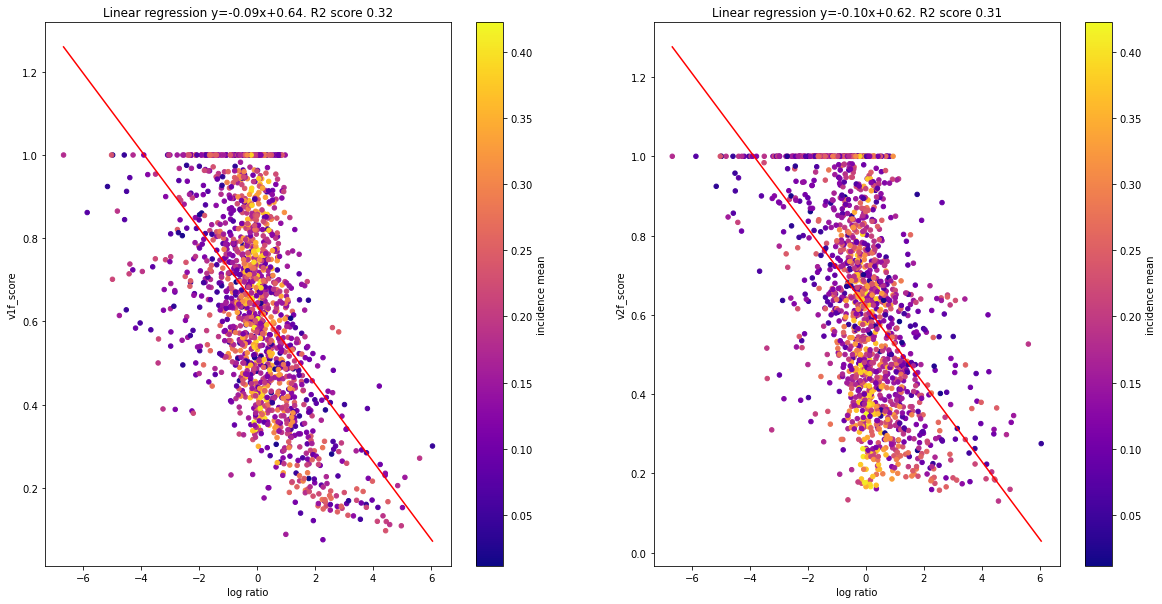

In [17]:
import sensitivity_analysis_functions as saf
import pandas as pd
#print(pd.__version__)
MI_analysis = False
linear_reg = True
regression_on_cols = ['v1f_score','v2f_score']
target_results_cols = ['v1f_score','v2f_score']

Louvain_version = '3'
df_correlations=pd.read_csv("..\Results\multiple_pop_correlations_index.csv",index_col = 0)
df_Louvain = pd.read_csv("..\Results\Louvain_{0}_results.csv".format(Louvain_version),index_col = 0)
#display(df_correlations.head(5))
#display(df_Louvain.head(5))
df = pd.concat([df_correlations,df_Louvain], axis = 1)
#print(df.columns)
# show overall results 
meanv1_fscore = df['v1f_score'].mean()
meanv2_fscore = df['v2f_score'].mean()
df_similar = df.loc[df['individuals within populations similar'] == True]
meanv1_sim = df_similar['v1f_score'].mean()
meanv2_sim = df_similar['v2f_score'].mean()
print("Overall results for Louvain version {0}".format(Louvain_version))
print("Mean f-score for Louvain community detection for v1/v2 sigma across all results is {0}/{1}".format(meanv1_fscore,meanv2_fscore))
print("Mean f-score when only counting populations of similar individuals is {0}/{1}".format(meanv1_sim,meanv2_sim))

#display(df.head(5))

if MI_analysis:
    # for explanations of parameters/results headings set verbose to True
    # for MI comparisons against all versions of the results, set all_results to True
    # to display more/fewer MI values, reduce/increase cutoff
    # to display scattergraphs of all associations above cutoff value, set display_scattergraphs to True
    saf.mutual_information_analysis(df,verbose=False,all_results=False,target_results_cols = target_results_cols,cutoff=0.1,display_scattergraphs=True)
    
elif linear_reg:
    # linear regression will be on the feature passed as 'regression_feature' (useful to see scattergraphs even if regression line not meaningful in most cases)
    # if only_similar_individuals is True, half the runs will be discarded (those which cannot be meaningfully analysed using v2 sigma)
    # if only_similar_individuals is False, all runs will be included (so half of the v2 sigma results will be noise).
    # color_map_col can be changed to any feature parameter and will color the scatterplot by this parameter.
    saf.linear_regression_analysis(df,regression_feature = 'log ratio', regression_on_cols = regression_on_cols, only_similar_individuals = True,
                               color_map_col = 'incidence mean')




Cell below reads in the index file for Louvain results and continues to run Louvain on the corresponding correlation raw data from the last index.  An index can be passed in if it is required to repeat from a certain point.

In [2]:
import pointwise_correlation as pc
import testing_and_analysis_functions as taf
import pandas as pd
import Louvain
import numpy as np
import os

Louvain_version = '3'
Louvain_index_file = "{0}/Louvain_{1}_results.csv".format(pc.RESULTS_DIR,Louvain_version)
next_index = None
start_again = False
store_results = False

# turn index of correlation results into dataframe
i = np.random.randint(2999)
index_df=pd.read_csv("{0}".format(pc.INDEX_FILE),index_col = 0)
# load completed results csv into dataframe if it already exists
try:
    Louvain_results = pd.read_csv(Louvain_index_file, index_col = 0)
    # set next_index to the index to start running from
    if next_index:
        Louvain_results = Louvain_results.head(next_index)    
    else:
        next_index = Louvain_results.index[-1] + 1    
except FileNotFoundError:
    Louvain_results = pd.DataFrame()
    next_index = 0

if start_again:
    Louvain_results = pd.DataFrame()
    next_index = 0
    

# iterate through the stored index file, load the corresponding raw data and carry out Louvain community detection
# the partition and the scores are written to csv files in a sub-directory of the raw data directory
for index in index_df.index[next_index:]:
    data_dir = index_df.loc[index,'raw data directory']
    number_of_populations = index_df.loc[index,'number of populations']
    results_path = os.path.join(data_dir,"Louvain_{0}".format(Louvain_version))
    try:
        os.mkdir(results_path)
    except FileExistsError:
        pass
    
    if not store_results:
        results_path = ""
        
    v1_df, v2_df = taf.load_results_to_dfs(data_dir)
    meta_params = pd.read_csv("{0}/meta_params.csv".format(data_dir))
    params = pd.read_csv("{0}/population_parameters.csv".format(data_dir))
    
    results = {}
    for i, df in enumerate([v1_df, v2_df]):
        sigma_version = "v" + str(i+1)
        L_methods = Louvain.Louvain_methods(df,p_values_graph_setup_option = 'weights',resolution = 1,
                                                    store_results_dir = results_path, version = sigma_version, 
                                                    Louvain_version = Louvain_version, verbose=False)
    
        results[sigma_version] = L_methods.score_partition()#n.make_partition_and_score(df,test_random_graph=False,pass_weights=True,resolution = 1,
                                                    #store_results_dir = results_path, version = sigma_version, Louvain_version = Louvain_version, verbose=False)
    
    # append v2 results to v1 results in dict
    results['v1'].update(results['v2'])

    new_row = pd.DataFrame.from_dict(results['v1'])
    new_row['Louvain results path'] = results_path
    new_row['n'] = number_of_populations
    new_row.index = [index]
    if len(Louvain_results.index):
        Louvain_results = pd.concat([Louvain_results, new_row])
    else:
        Louvain_results = new_row
    
    if index == index_df.index[-1] or not index%30:
        # store accumulated results in csv file
        Louvain_results.to_csv(Louvain_index_file)
        print("{0}%".format(int(index/30), end = ","))
        display(Louvain_results.tail(1))
        
        print("Testing by reloading stored results....")
        print("Scores for v1...")
        display(pd.read_csv("{0}/Louvain_{1}/v1recall_precision_fscores.csv".format(data_dir, Louvain_version)))
        print("...and v2")
        display(pd.read_csv("{0}/Louvain_{1}/v2recall_precision_fscores.csv".format(data_dir, Louvain_version)))
        print("Confusion matrices for v1...")
        display(pd.read_csv("{0}/Louvain_{1}/v1confusion_matrix.csv".format(data_dir, Louvain_version)))
        print("...and v2")
        display(pd.read_csv("{0}/Louvain_{1}/v2confusion_matrix.csv".format(data_dir, Louvain_version)))
        
           
    
    
    
    

0%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
0,2,0.49,0.8,0.608,2,0.262,0.533,0.352,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Elena,Owen,Overall
0,Recall,0.400,0.500,0.138,0.490
1,Precison,1.000,1.000,0.400,0.800
2,F-score,0.571,0.667,0.205,0.608


...and v2


,Unnamed: 0,Rosa,Elena,Owen,Overall
0,Recall,0.162,0.125,0.162,0.262
1,Precison,0.600,0.400,0.600,0.533
2,F-score,0.255,0.190,0.255,0.352


Confusion matrices for v1...


,Unnamed: 0,Rosa,Owen,Elena
0,cluster 0,5.0,3,NaN
1,cluster 1,NaN,2,5.0


...and v2


,Unnamed: 0,Rosa,Owen,Elena
0,cluster 0,4,4,3
1,cluster 1,1,1,2


1%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
30,5,0.206,0.325,0.252,4,0.173,0.447,0.25,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.031,0.0,0.068,0.087,0.117,0.162,0.105,0.300,0.206
1,Precison,0.133,0.0,0.400,0.333,0.306,0.524,0.200,0.500,0.325
2,F-score,0.050,0.0,0.116,0.139,0.169,0.247,0.138,0.375,0.252


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.051,0.042,0.040,0.054,0.061,0.125,0.100,0.396,0.173
1,Precison,0.400,0.333,0.400,0.333,0.250,1.000,0.345,0.583,0.447
2,F-score,0.091,0.074,0.073,0.093,0.098,0.222,0.155,0.472,0.250


Confusion matrices for v1...


,Unnamed: 0,5,0,3,4,2,6,1,7
0,cluster 0,2.0,2.0,2.0,5.0,2.0,NaN,NaN,NaN
1,cluster 2,5.0,1.0,1.0,2.0,NaN,2.0,1.0,NaN
2,cluster 1,NaN,2.0,4.0,1.0,3.0,4.0,NaN,NaN
3,cluster 4,NaN,1.0,NaN,NaN,NaN,2.0,1.0,3.0
4,cluster 3,NaN,NaN,NaN,1.0,NaN,3.0,1.0,6.0


...and v2


,Unnamed: 0,6,5,0,3,4,2,7,1
0,cluster 0,6.0,7.0,4.0,4.0,4,3.0,NaN,NaN
1,cluster 2,2.0,NaN,1.0,1.0,1,NaN,1.0,2.0
2,cluster 3,3.0,NaN,NaN,2.0,3,2.0,1.0,1.0
3,cluster 1,NaN,NaN,1.0,NaN,1,NaN,7.0,NaN


2%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
60,7,0.37,0.5,0.425,4,0.116,0.268,0.162,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.312,0.407,0.088,0.314,0.333,0.057,0.039,0.600,0.370
1,Precison,0.714,0.524,0.286,0.524,1.000,0.143,0.095,0.714,0.500
2,F-score,0.435,0.458,0.135,0.393,0.500,0.081,0.056,0.652,0.425


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.041,0.041,0.069,0.049,0.034,0.135,0.058,0.079,0.116
1,Precison,0.190,0.190,0.333,0.190,0.143,0.476,0.286,0.333,0.268
2,F-score,0.068,0.067,0.115,0.078,0.055,0.211,0.097,0.127,0.162


Confusion matrices for v1...


,Unnamed: 0,7,5,3,2,0,6,1,4
0,cluster 0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 3,1.0,1.0,NaN,NaN,NaN,1.0,2.0,NaN
2,cluster 1,NaN,3.0,5.0,1.0,NaN,NaN,NaN,NaN
3,cluster 5,NaN,1.0,NaN,3.0,NaN,2.0,NaN,7.0
4,cluster 6,NaN,1.0,NaN,3.0,6.0,1.0,NaN,NaN
5,cluster 2,NaN,NaN,2.0,NaN,1.0,1.0,NaN,NaN
6,cluster 4,NaN,NaN,NaN,NaN,NaN,2.0,5.0,NaN


...and v2


,Unnamed: 0,7,5,6,4,2,0,1,3
0,cluster 0,2.0,1.0,4,2,4.0,3,3,1
1,cluster 2,4.0,NaN,1,1,1.0,1,2,3
2,cluster 3,1.0,1.0,1,2,2.0,1,1,2
3,cluster 1,NaN,5.0,1,2,NaN,2,1,1


3%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
90,2,1.0,1.0,1.0,2,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Owen,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Flo,Owen,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Flo,Owen
0,cluster 0,15.0,NaN
1,cluster 1,NaN,15.0


...and v2


,Unnamed: 0,Flo,Owen
0,cluster 0,15.0,NaN
1,cluster 1,NaN,15.0


4%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
120,8,0.603,0.627,0.615,4,0.115,0.261,0.16,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.079,0.548,0.560,0.524,0.564,0.750,0.414,0.274,0.603
1,Precison,0.154,0.590,0.538,0.705,0.846,1.000,0.705,0.474,0.627
2,F-score,0.104,0.568,0.549,0.601,0.677,0.857,0.521,0.347,0.615


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.053,0.068,0.055,0.079,0.059,0.054,0.056,0.062,0.115
1,Precison,0.231,0.321,0.244,0.359,0.218,0.231,0.256,0.231,0.261
2,F-score,0.086,0.112,0.090,0.130,0.093,0.088,0.093,0.097,0.160


Confusion matrices for v1...


,Unnamed: 0,4,7,6,3,0,1,5,2
0,cluster 0,12.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,1.0,NaN,11.0,NaN,4.0,NaN,NaN,NaN
2,cluster 1,NaN,9.0,NaN,1.0,3.0,2.0,NaN,NaN
3,cluster 3,NaN,1.0,NaN,NaN,1.0,NaN,13.0,NaN
4,cluster 4,NaN,2.0,1.0,NaN,3.0,NaN,NaN,4.0
5,cluster 5,NaN,NaN,NaN,11.0,1.0,1.0,NaN,NaN
6,cluster 6,NaN,NaN,NaN,NaN,1.0,NaN,NaN,9.0
7,cluster 7,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN


...and v2


,Unnamed: 0,4,5,1,6,0,7,3,2
0,cluster 0,2,5,7,6,5,2,7.0,5
1,cluster 1,5,2,2,3,2,5,NaN,4
2,cluster 2,3,2,3,2,4,4,2.0,3
3,cluster 3,3,4,1,2,2,2,4.0,1


5%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
150,6,0.526,0.681,0.594,4,0.144,0.282,0.191,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.333,0.0,0.60,0.583,0.440,0.032,0.455,0.222,0.526
1,Precison,1.000,0.0,1.00,0.778,0.524,0.333,1.000,0.311,0.681
2,F-score,0.500,0.0,0.75,0.667,0.478,0.059,0.625,0.259,0.594


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.069,0.0,0.045,0.134,0.061,0.033,0.111,0.085,0.144
1,Precison,0.286,0.0,0.190,0.361,0.238,0.333,0.467,0.222,0.282
2,F-score,0.111,0.0,0.073,0.195,0.097,0.061,0.179,0.123,0.191


Confusion matrices for v1...


,Unnamed: 0,3,1,7,0,5,6,4,2
0,cluster 0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,3.0,7.0,2.0,NaN,NaN,NaN
2,cluster 4,NaN,1.0,5.0,NaN,NaN,NaN,NaN,NaN
3,cluster 5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,7.0
4,cluster 2,NaN,NaN,NaN,NaN,1.0,6.0,2.0,NaN
5,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN


...and v2


,Unnamed: 0,3,7,2,4,6,0,1,5
0,cluster 0,5.0,3,1,2.0,NaN,NaN,NaN,NaN
1,cluster 1,3.0,4,3,2.0,2.0,3.0,1.0,NaN
2,cluster 2,1.0,2,1,NaN,4.0,1.0,NaN,1.0
3,cluster 3,NaN,1,2,3.0,NaN,3.0,1.0,2.0


6%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
180,7,0.707,0.908,0.795,6,0.297,0.457,0.36,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,1.0,0.643,0.869,0.321,0.714,0.321,0.818,0.500,0.707
1,Precison,1.0,1.000,0.895,1.000,0.801,1.000,1.000,0.567,0.908
2,F-score,1.0,0.783,0.882,0.486,0.755,0.486,0.900,0.532,0.795


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.093,0.209,0.107,0.185,0.394,0.355,0.116,0.140,0.297
1,Precison,0.251,0.444,0.357,0.620,0.620,0.567,0.374,0.421,0.457
2,F-score,0.136,0.285,0.164,0.285,0.482,0.437,0.177,0.210,0.360


Confusion matrices for v1...


,Unnamed: 0,3,5,6,4,2,7,1,0
0,cluster 0,19.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,19.0,2.0,NaN,NaN,NaN,NaN
2,cluster 4,NaN,NaN,NaN,17.0,NaN,1.0,NaN,NaN
3,cluster 2,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN
4,cluster 5,NaN,NaN,NaN,NaN,1.0,4.0,19.0,NaN
5,cluster 3,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0


...and v2


,Unnamed: 0,6,7,0,3,2,4,5,1
0,cluster 0,11.0,1.0,6.0,15.0,5.0,1.0,NaN,NaN
1,cluster 1,4.0,9.0,2.0,2.0,10.0,2.0,4.0,1.0
2,cluster 4,1.0,NaN,NaN,1.0,NaN,1.0,14.0,NaN
3,cluster 5,3.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN
4,cluster 3,NaN,9.0,4.0,1.0,4.0,NaN,NaN,11.0
5,cluster 2,NaN,NaN,7.0,NaN,NaN,NaN,1.0,7.0


7%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
210,4,0.62,0.941,0.748,4,0.492,0.726,0.586,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.875,0.733,0.053,0.048,0.040,0.538,0.167,0.0,0.100,0.620
1,Precison,1.000,1.000,1.000,1.000,1.000,1.000,0.500,0.0,1.000,0.941
2,F-score,0.933,0.846,0.100,0.091,0.077,0.700,0.250,0.0,0.182,0.748


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.875,0.245,0.091,0.0,0.0,0.451,0.138,0.0,0.027,0.492
1,Precison,1.000,0.591,1.000,0.0,0.0,0.657,0.444,0.0,0.333,0.726
2,F-score,0.933,0.347,0.167,0.0,0.0,0.535,0.211,0.0,0.050,0.586


Confusion matrices for v1...


,Unnamed: 0,5,6,2,4,1,0,7,8,3
0,cluster 0,15.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 3,NaN,6.0,NaN,NaN,NaN,NaN,1.0,3.0,2.0
2,cluster 1,NaN,NaN,NaN,2.0,12.0,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,NaN,NaN,NaN,15.0,1.0,NaN,NaN


...and v2


,Unnamed: 0,5,8,4,7,6,1,3,2,0
0,cluster 0,12.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,3.0,NaN,1.0,1.0,4.0,9.0,1.0,NaN,NaN
2,cluster 2,NaN,2.0,NaN,NaN,5.0,3.0,NaN,3.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,15.0


8%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
240,3,0.531,1.0,0.694,4,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Elena,Owen,Overall
0,Recall,0.400,0.167,1.0,1.0,0.531
1,Precison,1.000,1.000,1.0,1.0,1.000
2,F-score,0.571,0.286,1.0,1.0,0.694


...and v2


,Unnamed: 0,Tom,Rosa,Elena,Owen,Overall
0,Recall,1.0,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Elena,Tom,Rosa,Owen
0,cluster 0,2.0,NaN,NaN,NaN
1,cluster 1,NaN,5.0,3.0,NaN
2,cluster 2,NaN,NaN,NaN,3.0


...and v2


,Unnamed: 0,Elena,Rosa,Owen,Tom
0,cluster 0,2.0,NaN,NaN,NaN
1,cluster 1,NaN,3.0,NaN,NaN
2,cluster 2,NaN,NaN,3.0,NaN
3,cluster 3,NaN,NaN,NaN,5.0


9%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
270,5,0.607,0.91,0.728,6,0.972,0.974,0.973,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Luke,Owen,Overall
0,Recall,0.261,1.0,0.695,0.372,1.0,0.261,0.607
1,Precison,1.000,1.0,0.846,0.615,1.0,1.000,0.910
2,F-score,0.414,1.0,0.763,0.464,1.0,0.414,0.728


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Luke,Owen,Overall
0,Recall,0.857,1.0,0.835,1.0,1.0,1.0,0.972
1,Precison,1.000,1.0,0.846,1.0,1.0,1.0,0.974
2,F-score,0.923,1.0,0.841,1.0,1.0,1.0,0.973


Confusion matrices for v1...


,Unnamed: 0,Rosa,Flo,Owen,Tom,Jill,Luke
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,3.0,13.0,13.0,1.0,NaN
2,cluster 2,NaN,10.0,NaN,NaN,NaN,NaN
3,cluster 4,NaN,NaN,NaN,NaN,12.0,NaN
4,cluster 3,NaN,NaN,NaN,NaN,NaN,13.0


...and v2


,Unnamed: 0,Rosa,Jill,Flo,Luke,Owen,Tom
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,12.0,NaN,NaN,NaN,NaN
2,cluster 5,NaN,1.0,NaN,NaN,NaN,13.0
3,cluster 2,NaN,NaN,13.0,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,13.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,13.0,NaN


10%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
300,2,0.846,0.688,0.759,2,0.538,0.438,0.483,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Jill,Overall
0,Recall,0.333,0.833,0.846
1,Precison,1.000,0.667,0.688
2,F-score,0.500,0.741,0.759


...and v2


,Unnamed: 0,Rosa,Jill,Overall
0,Recall,0.143,0.500,0.538
1,Precison,1.000,0.400,0.438
2,F-score,0.250,0.444,0.483


Confusion matrices for v1...


,Unnamed: 0,Rosa,Jill
0,cluster 0,2.0,1
1,cluster 1,NaN,5


...and v2


,Unnamed: 0,Rosa,Jill
0,cluster 0,2.0,3
1,cluster 1,NaN,3


11%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
330,5,0.594,0.905,0.718,5,0.757,0.911,0.827,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.209,0.556,0.444,0.847,0.0,0.095,0.500,0.594
1,Precison,1.000,1.000,1.000,0.875,0.0,0.190,1.000,0.905
2,F-score,0.346,0.714,0.615,0.861,0.0,0.127,0.667,0.718


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.581,0.238,0.930,0.789,0.040,0.188,1.0,0.757
1,Precison,0.800,1.000,0.882,1.000,1.000,0.714,1.0,0.911
2,F-score,0.673,0.385,0.906,0.882,0.077,0.297,1.0,0.827


Confusion matrices for v1...


,Unnamed: 0,4,1,5,6,2,0,3
0,cluster 0,1.0,6.0,1.0,NaN,NaN,NaN,NaN
1,cluster 4,1.0,NaN,3.0,NaN,NaN,NaN,1.0
2,cluster 1,NaN,NaN,2.0,5.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,1.0,NaN,NaN,NaN,15.0
4,cluster 2,NaN,NaN,NaN,NaN,17.0,10.0,NaN


...and v2


,Unnamed: 0,3,0,5,1,4,6,2
0,cluster 0,16.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 4,NaN,9.0,NaN,NaN,NaN,NaN,1.0
2,cluster 1,NaN,NaN,6.0,6.0,2.0,NaN,NaN
3,cluster 2,NaN,NaN,NaN,NaN,NaN,5.0,NaN
4,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,16.0


12%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
360,3,0.513,0.851,0.64,2,0.326,0.979,0.489,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Flo,Elena,Owen,Overall
0,Recall,0.333,0.714,0.133,0.0,0.455,0.513
1,Precison,1.000,1.000,0.400,0.0,1.000,0.851
2,F-score,0.500,0.833,0.200,0.0,0.625,0.640


...and v2


,Unnamed: 0,Tom,Rosa,Flo,Elena,Owen,Overall
0,Recall,0.111,0.714,0.154,0.0,0.200,0.326
1,Precison,1.000,1.000,1.000,0.0,1.000,0.979
2,F-score,0.200,0.833,0.267,0.0,0.333,0.489


Confusion matrices for v1...


,Unnamed: 0,Flo,Owen,Elena,Tom,Rosa
0,cluster 0,2.0,6.0,1.0,NaN,NaN
1,cluster 1,3.0,NaN,NaN,4.0,NaN
2,cluster 2,NaN,NaN,1.0,NaN,6.0


...and v2


,Unnamed: 0,Flo,Owen,Tom,Elena,Rosa
0,cluster 0,5.0,6.0,4.0,1,NaN
1,cluster 1,NaN,NaN,NaN,1,6.0


13%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
390,3,0.925,0.902,0.914,2,0.732,1.0,0.845,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Flo,Owen,Overall
0,Recall,1.0,0.667,0.500,0.925
1,Precison,1.0,0.600,1.000,0.902
2,F-score,1.0,0.632,0.667,0.914


...and v2


,Unnamed: 0,Rosa,Flo,Owen,Overall
0,Recall,1.0,0.400,0.167,0.732
1,Precison,1.0,1.000,1.000,1.000
2,F-score,1.0,0.571,0.286,0.845


Confusion matrices for v1...


,Unnamed: 0,Rosa,Flo,Owen
0,cluster 0,8.0,NaN,NaN
1,cluster 1,NaN,4.0,NaN
2,cluster 2,NaN,1.0,3.0


...and v2


,Unnamed: 0,Rosa,Flo,Owen
0,cluster 0,8.0,NaN,NaN
1,cluster 1,NaN,5.0,3.0


14%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
420,4,0.635,0.956,0.763,4,0.309,0.406,0.351,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Elena,Owen,Overall
0,Recall,0.286,1.0,0.609,0.286,1.0,0.635
1,Precison,1.000,1.0,0.778,1.000,1.0,0.956
2,F-score,0.444,1.0,0.683,0.444,1.0,0.763


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Elena,Owen,Overall
0,Recall,0.135,0.361,0.080,0.219,0.180,0.309
1,Precison,0.333,0.611,0.194,0.444,0.444,0.406
2,F-score,0.192,0.454,0.114,0.294,0.256,0.351


Confusion matrices for v1...


,Unnamed: 0,Rosa,Elena,Tom,Jill,Owen
0,cluster 0,9.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,9.0,9.0,1.0,NaN
2,cluster 3,NaN,NaN,NaN,8.0,NaN
3,cluster 2,NaN,NaN,NaN,NaN,9.0


...and v2


,Unnamed: 0,Rosa,Owen,Tom,Jill,Elena
0,cluster 0,2.0,4.0,4.0,1,NaN
1,cluster 1,7.0,NaN,NaN,2,1.0
2,cluster 2,NaN,5.0,4.0,3,2.0
3,cluster 3,NaN,NaN,1.0,3,6.0


15%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
450,3,1.0,1.0,1.0,3,0.319,0.348,0.333,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Jill,Flo,Overall
0,Recall,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0


...and v2


,Unnamed: 0,Rosa,Jill,Flo,Overall
0,Recall,0.213,0.181,0.174,0.319
1,Precison,0.412,0.309,0.324,0.348
2,F-score,0.281,0.228,0.226,0.333


Confusion matrices for v1...


,Unnamed: 0,Jill,Rosa,Flo
0,cluster 0,17.0,NaN,NaN
1,cluster 1,NaN,17.0,NaN
2,cluster 2,NaN,NaN,17.0


...and v2


,Unnamed: 0,Jill,Rosa,Flo
0,cluster 0,4,5,5
1,cluster 1,7,2,4
2,cluster 2,6,10,8


16%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
480,3,0.893,0.658,0.758,2,0.758,0.76,0.759,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Owen,Overall
0,Recall,0.727,0.850,0.893
1,Precison,0.421,0.895,0.658
2,F-score,0.533,0.872,0.758


...and v2


,Unnamed: 0,Elena,Owen,Overall
0,Recall,0.597,0.623,0.758
1,Precison,0.719,0.801,0.760
2,F-score,0.653,0.701,0.759


Confusion matrices for v1...


,Unnamed: 0,Owen,Elena
0,cluster 0,18.0,1
1,cluster 1,1.0,9
2,cluster 2,NaN,9


...and v2


,Unnamed: 0,Elena,Owen
0,cluster 0,16,2
1,cluster 1,3,17


17%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
510,3,1.0,1.0,1.0,2,0.868,1.0,0.93,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Owen,Overall
0,Recall,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0


...and v2


,Unnamed: 0,Tom,Rosa,Owen,Overall
0,Recall,0.500,1.0,0.091,0.868
1,Precison,1.000,1.0,1.000,1.000
2,F-score,0.667,1.0,0.167,0.930


Confusion matrices for v1...


,Unnamed: 0,Rosa,Tom,Owen
0,cluster 0,11.0,NaN,NaN
1,cluster 1,NaN,5.0,NaN
2,cluster 2,NaN,NaN,2.0


...and v2


,Unnamed: 0,Rosa,Tom,Owen
0,cluster 0,11.0,NaN,NaN
1,cluster 1,NaN,5.0,2.0


18%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
540,7,0.533,0.663,0.591,5,0.327,0.636,0.431,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.710,0.169,0.294,0.080,0.778,0.298,0.0,1.0,0.375,0.533
1,Precison,0.846,0.220,1.000,0.400,1.000,0.655,0.0,1.0,1.000,0.663
2,F-score,0.772,0.191,0.455,0.133,0.875,0.409,0.0,1.0,0.545,0.591


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.187,0.107,0.714,0.075,0.538,0.209,0.02,0.226,0.429,0.327
1,Precison,0.487,0.275,1.000,0.667,1.000,0.818,1.00,1.000,1.000,0.636
2,F-score,0.270,0.154,0.833,0.134,0.700,0.333,0.04,0.368,0.600,0.431


Confusion matrices for v1...


,Unnamed: 0,1,8,5,0,3,6,4,7,2
0,cluster 0,4.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,cluster 5,5.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,6.0
3,cluster 6,2.0,NaN,9.0,NaN,4.0,1.0,NaN,NaN,NaN
4,cluster 2,NaN,NaN,NaN,12.0,1.0,1.0,NaN,NaN,NaN
5,cluster 3,NaN,NaN,NaN,NaN,1.0,NaN,8.0,NaN,NaN
6,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN


...and v2


,Unnamed: 0,8,1,5,7,0,3,4,2,6
0,cluster 0,7.0,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,2,NaN,8.0,9.0,1.0,NaN,NaN,NaN
2,cluster 2,NaN,1,NaN,NaN,2.0,NaN,8.0,NaN,NaN
3,cluster 3,NaN,1,NaN,NaN,NaN,NaN,NaN,6.0,NaN
4,cluster 4,NaN,7,10.0,NaN,2.0,5.0,NaN,NaN,2.0


19%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
570,2,0.559,1.0,0.717,2,0.412,0.737,0.528,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Flo,Elena,Overall
0,Recall,1.0,0.167,0.400,0.559
1,Precison,1.0,1.000,1.000,1.000
2,F-score,1.0,0.286,0.571,0.717


...and v2


,Unnamed: 0,Tom,Flo,Elena,Overall
0,Recall,0.231,0.062,0.400,0.412
1,Precison,0.500,0.333,1.000,0.737
2,F-score,0.316,0.105,0.571,0.528


Confusion matrices for v1...


,Unnamed: 0,Tom,Elena,Flo
0,cluster 0,4.0,NaN,NaN
1,cluster 1,NaN,5.0,3.0


...and v2


,Unnamed: 0,Elena,Tom,Flo
0,cluster 0,5.0,1,2
1,cluster 1,NaN,3,1


20%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
600,8,0.529,0.462,0.493,4,0.173,0.308,0.222,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.475,0.469,0.048,0.556,0.328,0.098,0.354,0.778,0.529
1,Precison,0.778,0.714,1.000,1.000,0.750,0.103,0.267,1.000,0.462
2,F-score,0.589,0.566,0.091,0.714,0.457,0.100,0.304,0.875,0.493


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.049,0.058,0.0,0.064,0.167,0.115,0.150,0.039,0.173
1,Precison,0.194,0.286,0.0,0.400,0.571,0.282,0.324,0.179,0.308
2,F-score,0.078,0.097,0.0,0.110,0.258,0.164,0.205,0.065,0.222


Confusion matrices for v1...


,Unnamed: 0,7,5,4,6,2,1,0,3
0,cluster 0,8.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,1,7.0,1.0,2.0,1.0,NaN,NaN
2,cluster 2,NaN,1,NaN,NaN,NaN,6.0,NaN,NaN
3,cluster 3,NaN,2,NaN,1.0,NaN,NaN,8.0,NaN
4,cluster 4,NaN,1,NaN,NaN,NaN,NaN,1.0,6.0
5,cluster 5,NaN,4,NaN,2.0,NaN,NaN,NaN,NaN
6,cluster 6,NaN,1,1.0,7.0,NaN,NaN,NaN,NaN
7,cluster 7,NaN,2,NaN,4.0,NaN,NaN,NaN,NaN


...and v2


,Unnamed: 0,7,0,5,3,6,1,4,2
0,cluster 0,3,3,4,1.0,8,1,NaN,NaN
1,cluster 1,1,2,6,NaN,3,4,NaN,NaN
2,cluster 2,2,1,1,1.0,1,1,6.0,1.0
3,cluster 3,2,3,2,4.0,3,1,2.0,1.0


21%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
630,4,0.333,0.48,0.393,1,0.167,1.0,0.286,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Jill,Flo,Luke,Owen,Overall
0,Recall,0.130,0.176,0.240,0.067,0.400,0.333
1,Precison,0.300,0.300,0.600,0.200,1.000,0.480
2,F-score,0.182,0.222,0.343,0.100,0.571,0.393


...and v2


,Unnamed: 0,Rosa,Jill,Flo,Luke,Owen,Overall
0,Recall,0.091,0.091,0.091,0.091,0.091,0.167
1,Precison,1.000,1.000,1.000,1.000,1.000,1.000
2,F-score,0.167,0.167,0.167,0.167,0.167,0.286


Confusion matrices for v1...


,Unnamed: 0,Rosa,Owen,Luke,Jill,Flo
0,cluster 0,1.0,5.0,2.0,NaN,NaN
1,cluster 1,3.0,NaN,1.0,1.0,NaN
2,cluster 2,1.0,NaN,2.0,1.0,4.0
3,cluster 3,NaN,NaN,NaN,3.0,1.0


...and v2


,Unnamed: 0,Rosa,Flo,Luke,Jill,Owen
0,cluster 0,5,5,5,5,5


22%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
660,5,0.556,0.652,0.6,4,0.204,0.359,0.26,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.370,0.435,0.0,0.323,0.091,0.824,0.091,0.556
1,Precison,0.667,0.476,0.0,0.667,1.000,0.778,1.000,0.652
2,F-score,0.476,0.455,0.0,0.435,0.167,0.800,0.167,0.600


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.097,0.090,0.031,0.231,0.091,0.160,0.0,0.204
1,Precison,0.400,0.286,0.333,0.400,1.000,0.361,0.0,0.359
2,F-score,0.156,0.136,0.057,0.293,0.167,0.222,0.0,0.260


Confusion matrices for v1...


,Unnamed: 0,5,6,1,4,2,3,0
0,cluster 0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,2.0,1.0,2.0,1.0,NaN,NaN
2,cluster 2,NaN,NaN,5.0,NaN,NaN,NaN,NaN
3,cluster 3,NaN,NaN,1.0,NaN,1.0,5.0,1.0
4,cluster 4,NaN,NaN,NaN,NaN,1.0,1.0,5.0


...and v2


,Unnamed: 0,5,0,1,2,3,4,6
0,cluster 0,5.0,4.0,4,2.0,NaN,NaN,NaN
1,cluster 2,1.0,1.0,1,NaN,1.0,2.0,1.0
2,cluster 3,3.0,1.0,1,NaN,1.0,NaN,1.0
3,cluster 1,NaN,NaN,1,1.0,4.0,NaN,NaN


23%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
690,5,0.326,0.689,0.443,4,0.111,0.289,0.16,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,1.0,0.071,0.154,0.286,0.098,0.154,0.286,0.286,0.071,0.326
1,Precison,1.0,0.300,0.600,1.000,0.400,0.600,1.000,1.000,0.300,0.689
2,F-score,1.0,0.115,0.245,0.444,0.157,0.245,0.444,0.444,0.115,0.443


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.043,0.080,0.057,0.041,0.040,0.075,0.085,0.098,0.019,0.111
1,Precison,0.200,0.400,0.300,0.200,0.200,0.400,0.400,0.400,0.100,0.289
2,F-score,0.070,0.133,0.095,0.068,0.067,0.127,0.140,0.157,0.032,0.160


Confusion matrices for v1...


,Unnamed: 0,5,3,8,1,6,4,2,0,7
0,cluster 0,4.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,1.0,1.0,5.0,2.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,3.0,3.0,NaN,3.0,1.0,NaN,NaN
3,cluster 4,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,5.0
4,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN


...and v2


,Unnamed: 0,5,2,6,4,0,8,3,1,7
0,cluster 0,3.0,1.0,3.0,2.0,2.0,1,NaN,NaN,NaN
1,cluster 1,2.0,3.0,NaN,1.0,NaN,2,2.0,3.0,NaN
2,cluster 3,NaN,1.0,2.0,NaN,2.0,1,1.0,NaN,3.0
3,cluster 2,NaN,NaN,NaN,2.0,1.0,1,2.0,2.0,2.0


24%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
720,7,0.632,0.261,0.37,3,0.299,0.301,0.3,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Jill,Owen,Overall
0,Recall,0.325,0.563,0.484,0.632
1,Precison,0.170,0.320,0.294,0.261
2,F-score,0.223,0.408,0.366,0.370


...and v2


,Unnamed: 0,Rosa,Jill,Owen,Overall
0,Recall,0.175,0.175,0.177,0.299
1,Precison,0.301,0.301,0.301,0.301
2,F-score,0.221,0.221,0.223,0.300


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill,Rosa
0,cluster 0,6.0,1.0,1
1,cluster 1,8.0,1.0,1
2,cluster 2,2.0,NaN,4
3,cluster 5,2.0,1.0,5
4,cluster 3,NaN,8.0,1
5,cluster 4,NaN,7.0,1
6,cluster 6,NaN,NaN,5


...and v2


,Unnamed: 0,Owen,Rosa,Jill
0,cluster 0,5,6,6
1,cluster 1,7,5,5
2,cluster 2,6,7,7


25%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
750,3,0.765,0.605,0.675,2,0.58,0.93,0.714,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Elena,Luke,Overall
0,Recall,0.786,0.273,0.333,0.765
1,Precison,0.611,0.500,1.000,0.605
2,F-score,0.688,0.353,0.500,0.675


...and v2


,Unnamed: 0,Jill,Elena,Luke,Overall
0,Recall,0.571,0.094,0.333,0.580
1,Precison,1.000,0.500,1.000,0.930
2,F-score,0.727,0.158,0.500,0.714


Confusion matrices for v1...


,Unnamed: 0,Jill,Elena,Luke
0,cluster 0,7.0,NaN,NaN
1,cluster 1,2.0,3.0,NaN
2,cluster 2,NaN,1.0,2.0


...and v2


,Unnamed: 0,Elena,Jill,Luke
0,cluster 0,3,9.0,NaN
1,cluster 1,1,NaN,2.0


26%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
780,9,0.191,0.127,0.153,4,0.158,0.381,0.224,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Luke,Overall
0,Recall,0.104,0.083,0.098,0.107,0.170,0.064,0.191
1,Precison,0.125,0.096,0.118,0.132,0.221,0.074,0.127
2,F-score,0.114,0.089,0.107,0.118,0.192,0.068,0.153


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Luke,Overall
0,Recall,0.082,0.068,0.110,0.094,0.076,0.075,0.158
1,Precison,0.375,0.250,0.581,0.456,0.301,0.324,0.381
2,F-score,0.135,0.107,0.185,0.156,0.122,0.122,0.224


Confusion matrices for v1...


,Unnamed: 0,Tom,Flo,Luke,Jill,Rosa,Elena
0,cluster 0,4.0,6,1,1.0,1,NaN
1,cluster 1,2.0,2,3,NaN,3,1.0
2,cluster 3,4.0,1,2,1.0,1,2.0
3,cluster 4,3.0,1,2,2.0,1,2.0
4,cluster 6,2.0,1,2,1.0,3,1.0
5,cluster 7,1.0,2,1,3.0,1,8.0
6,cluster 8,1.0,1,2,4.0,1,1.0
7,cluster 2,NaN,2,3,1.0,2,1.0
8,cluster 5,NaN,1,1,4.0,4,1.0


...and v2


,Unnamed: 0,Jill,Flo,Tom,Rosa,Luke,Elena
0,cluster 0,13,11.0,10,7,9,8
1,cluster 1,2,2.0,3,2,2,5
2,cluster 2,1,NaN,1,4,2,3
3,cluster 3,1,4.0,3,4,4,1


27%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
810,4,0.208,0.167,0.185,2,0.245,0.4,0.304,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Flo,Owen,Overall
0,Recall,0.067,0.143,0.143,0.208
1,Precison,0.100,0.200,0.200,0.167
2,F-score,0.080,0.167,0.167,0.185


...and v2


,Unnamed: 0,Tom,Flo,Owen,Overall
0,Recall,0.138,0.143,0.138,0.245
1,Precison,0.400,0.400,0.400,0.400
2,F-score,0.205,0.211,0.205,0.304


Confusion matrices for v1...


,Unnamed: 0,Tom,Flo,Owen
0,cluster 0,2,2.0,2.0
1,cluster 1,1,NaN,2.0
2,cluster 2,1,2.0,NaN
3,cluster 3,1,1.0,1.0


...and v2


,Unnamed: 0,Tom,Flo,Owen
0,cluster 0,3,2,3
1,cluster 1,2,3,2


28%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
840,8,0.738,0.838,0.785,6,0.743,0.93,0.826,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.556,0.207,1.000,1.0,0.75,1.0,0.750,0.263,0.738
1,Precison,1.000,0.462,0.455,1.0,0.75,1.0,1.000,1.000,0.838
2,F-score,0.714,0.286,0.625,1.0,0.75,1.0,0.857,0.417,0.785


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,1.0,1.0,0.250,0.700,0.412,0.733,0.147,0.238,0.743
1,Precison,1.0,1.0,0.564,1.000,1.000,1.000,0.524,1.000,0.930
2,F-score,1.0,1.0,0.346,0.824,0.583,0.846,0.229,0.385,0.826


Confusion matrices for v1...


,Unnamed: 0,1,7,2,5,3,0,4,6
0,cluster 0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 5,6.0,NaN,NaN,NaN,NaN,16.0,NaN,NaN
2,cluster 1,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
3,cluster 4,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
4,cluster 2,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN
5,cluster 3,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN
7,cluster 7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,7.0


...and v2


,Unnamed: 0,1,3,2,0,4,6,7,5
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,15.0,3.0,NaN,NaN,NaN,NaN,NaN
2,cluster 4,NaN,NaN,8.0,NaN,NaN,NaN,6.0,NaN
3,cluster 2,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,NaN,8.0,5.0,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,12.0


29%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
870,6,0.312,0.347,0.329,5,0.279,0.416,0.334,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.141,0.444,0.294,0.155,0.122,0.029,0.163,0.263,0.312
1,Precison,0.184,1.000,1.000,0.267,0.600,0.133,0.250,1.000,0.347
2,F-score,0.160,0.615,0.455,0.196,0.203,0.048,0.197,0.417,0.329


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.136,0.267,0.714,0.112,0.069,0.059,0.187,0.263,0.279
1,Precison,0.243,1.000,1.000,0.267,0.600,0.400,0.408,1.000,0.416
2,F-score,0.174,0.421,0.833,0.157,0.124,0.103,0.257,0.417,0.334


Confusion matrices for v1...


,Unnamed: 0,0,5,3,4,6,2,7,1
0,cluster 0,5.0,1.0,2.0,1.0,3.0,NaN,NaN,NaN
1,cluster 1,3.0,2.0,1.0,NaN,NaN,6.0,NaN,NaN
2,cluster 2,5.0,NaN,1.0,NaN,1.0,NaN,6.0,NaN
3,cluster 3,2.0,1.0,7.0,NaN,7.0,NaN,NaN,NaN
4,cluster 5,2.0,2.0,NaN,4.0,4.0,NaN,NaN,NaN
5,cluster 4,NaN,NaN,4.0,NaN,1.0,NaN,NaN,9.0


...and v2


,Unnamed: 0,0,5,3,4,6,2,7,1
0,cluster 0,7,4.0,3.0,1.0,3.0,NaN,NaN,NaN
1,cluster 1,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN
2,cluster 2,4,1.0,7.0,NaN,10.0,NaN,NaN,NaN
3,cluster 3,4,NaN,2.0,NaN,1.0,NaN,6.0,NaN
4,cluster 4,1,1.0,3.0,4.0,2.0,NaN,NaN,9.0


30%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
900,5,0.587,0.6,0.593,4,0.207,0.311,0.249,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Luke,Overall
0,Recall,0.220,0.507,0.655,0.235,0.592,0.587
1,Precison,0.400,0.800,0.800,0.356,0.644,0.600
2,F-score,0.283,0.621,0.720,0.283,0.617,0.593


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Luke,Overall
0,Recall,0.091,0.123,0.166,0.080,0.111,0.207
1,Precison,0.267,0.311,0.533,0.222,0.222,0.311
2,F-score,0.136,0.176,0.253,0.118,0.148,0.249


Confusion matrices for v1...


,Unnamed: 0,Luke,Flo,Tom,Rosa,Jill
0,cluster 0,2.0,5.0,1.0,NaN,NaN
1,cluster 1,8.0,NaN,NaN,1.0,NaN
2,cluster 3,NaN,4.0,6.0,NaN,1.0
3,cluster 4,NaN,1.0,NaN,NaN,9.0
4,cluster 2,NaN,NaN,3.0,9.0,NaN


...and v2


,Unnamed: 0,Rosa,Luke,Tom,Flo,Jill
0,cluster 0,3.0,3,2,3,NaN
1,cluster 2,2.0,2,5,4,7.0
2,cluster 3,5.0,1,2,2,3.0
3,cluster 1,NaN,4,1,1,NaN


31%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
930,6,0.296,0.5,0.372,4,0.136,0.356,0.196,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.083,0.10,0.400,0.316,0.286,0.061,0.167,0.033,0.222,0.296
1,Precison,0.300,0.30,1.000,0.600,1.000,0.200,0.400,0.100,0.600,0.500
2,F-score,0.130,0.15,0.571,0.414,0.444,0.093,0.235,0.050,0.324,0.372


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.093,0.107,0.038,0.041,0.098,0.070,0.038,0.107,0.065,0.136
1,Precison,0.400,0.600,0.200,0.200,0.400,0.300,0.200,0.600,0.300,0.356
2,F-score,0.151,0.182,0.063,0.068,0.157,0.113,0.063,0.182,0.107,0.196


Confusion matrices for v1...


,Unnamed: 0,7,2,0,1,8,3,6,5,4
0,cluster 0,1.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN
2,cluster 3,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN
3,cluster 4,1.0,NaN,NaN,1.0,NaN,1.0,2.0,1.0,NaN
4,cluster 1,NaN,NaN,1.0,NaN,1.0,4.0,NaN,NaN,NaN
5,cluster 5,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,5.0


...and v2


,Unnamed: 0,7,6,1,8,3,2,5,0,4
0,cluster 0,4.0,2.0,4.0,1.0,1.0,2.0,NaN,NaN,NaN
1,cluster 1,1.0,2.0,1.0,NaN,2.0,2.0,1.0,2.0,NaN
2,cluster 3,NaN,1.0,NaN,3.0,NaN,1.0,3.0,NaN,2.0
3,cluster 2,NaN,NaN,NaN,1.0,2.0,NaN,1.0,3.0,3.0


32%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
960,6,0.945,0.951,0.948,6,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Luke,Owen,Overall
0,Recall,1.0,1.0,0.679,1.0,0.857,0.857,0.945
1,Precison,1.0,1.0,0.705,1.0,1.000,1.000,0.951
2,F-score,1.0,1.0,0.692,1.0,0.923,0.923,0.948


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Luke,Owen,Overall
0,Recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Tom,Rosa,Jill,Luke,Owen,Flo
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,11.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,1.0,13.0,NaN,NaN
4,cluster 4,NaN,NaN,1.0,NaN,13.0,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,13.0


...and v2


,Unnamed: 0,Rosa,Tom,Luke,Owen,Jill,Flo
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,13.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,13.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,13.0,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,13.0


33%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
990,2,0.667,0.8,0.727,2,0.435,0.571,0.494,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Jill,Owen,Overall
0,Recall,0.778,0.091,0.333,0.667
1,Precison,0.750,1.000,1.000,0.800
2,F-score,0.764,0.167,0.500,0.727


...and v2


,Unnamed: 0,Tom,Jill,Owen,Overall
0,Recall,0.333,0.143,0.231,0.435
1,Precison,0.464,1.000,1.000,0.571
2,F-score,0.388,0.250,0.375,0.494


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill,Tom
0,cluster 0,4.0,2.0,1
1,cluster 1,NaN,NaN,7


...and v2


,Unnamed: 0,Owen,Tom,Jill
0,cluster 0,4.0,5,NaN
1,cluster 1,NaN,3,2.0


34%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1020,5,0.429,0.692,0.53,3,0.311,0.87,0.458,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.333,0.185,0.113,0.253,0.439,0.252,0.571,0.429
1,Precison,1.000,0.622,0.356,0.467,0.800,0.800,0.800,0.692
2,F-score,0.500,0.286,0.172,0.328,0.567,0.383,0.667,0.530


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.176,0.104,0.176,0.158,0.138,0.692,0.209,0.311
1,Precison,1.000,0.489,1.000,0.800,0.800,1.000,1.000,0.870
2,F-score,0.300,0.171,0.300,0.264,0.236,0.818,0.346,0.458


Confusion matrices for v1...


,Unnamed: 0,6,1,5,3,2,4,0
0,cluster 0,9.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 3,1.0,1.0,NaN,1.0,6.0,NaN,10.0
2,cluster 1,NaN,8.0,9.0,1.0,1.0,1.0,NaN
3,cluster 2,NaN,NaN,1.0,7.0,1.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,1.0,2.0,9.0,NaN


...and v2


,Unnamed: 0,6,3,1,4,5,0,2
0,cluster 0,10.0,9.0,7,1.0,NaN,NaN,NaN
1,cluster 2,NaN,1.0,1,9.0,NaN,10.0,10.0
2,cluster 1,NaN,NaN,2,NaN,10.0,NaN,NaN


35%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1050,4,0.792,0.955,0.865,6,0.992,0.971,0.981,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Luke,Owen,Overall
0,Recall,0.071,1.0,0.778,0.023,0.765,0.579,0.792
1,Precison,1.000,1.0,0.875,0.333,1.000,1.000,0.955
2,F-score,0.133,1.0,0.824,0.043,0.867,0.733,0.865


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Luke,Owen,Overall
0,Recall,0.500,1.0,1.0,1.0,1.0,0.948,0.992
1,Precison,1.000,1.0,1.0,1.0,1.0,0.833,0.971
2,F-score,0.667,1.0,1.0,1.0,1.0,0.887,0.981


Confusion matrices for v1...


,Unnamed: 0,Owen,Tom,Jill,Flo,Rosa,Luke
0,cluster 0,12.0,3.0,1.0,NaN,NaN,NaN
1,cluster 1,NaN,NaN,15.0,1.0,NaN,NaN
2,cluster 3,NaN,NaN,NaN,2.0,NaN,14.0
3,cluster 2,NaN,NaN,NaN,NaN,14.0,NaN


...and v2


,Unnamed: 0,Owen,Tom,Jill,Flo,Rosa,Luke
0,cluster 0,11.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,3.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,16.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,3.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,14.0,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,14.0


36%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1080,5,0.818,1.0,0.9,5,0.818,1.0,0.9,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Flo,Elena,Luke,Owen,Overall
0,Recall,0.429,1.0,1.0,0.111,1.0,1.0,0.818
1,Precison,1.000,1.0,1.0,1.000,1.0,1.0,1.000
2,F-score,0.600,1.0,1.0,0.200,1.0,1.0,0.900


...and v2


,Unnamed: 0,Tom,Rosa,Flo,Elena,Luke,Owen,Overall
0,Recall,0.429,1.0,1.0,0.111,1.0,1.0,0.818
1,Precison,1.000,1.0,1.0,1.000,1.0,1.0,1.000
2,F-score,0.600,1.0,1.0,0.200,1.0,1.0,0.900


Confusion matrices for v1...


,Unnamed: 0,Flo,Luke,Tom,Elena,Owen,Rosa
0,cluster 0,5.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,3.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,4.0,2.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,4.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,5.0


...and v2


,Unnamed: 0,Elena,Tom,Flo,Luke,Owen,Rosa
0,cluster 0,2.0,4.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,5.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,NaN,3.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,4.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,5.0


37%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1110,3,0.283,0.739,0.41,2,0.215,0.87,0.345,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Flo,Elena,Luke,Owen,Overall
0,Recall,0.111,0.067,0.231,0.333,0.200,0.091,0.283
1,Precison,0.500,1.000,1.000,0.500,1.000,1.000,0.739
2,F-score,0.182,0.125,0.375,0.400,0.333,0.167,0.410


...and v2


,Unnamed: 0,Tom,Rosa,Flo,Elena,Luke,Owen,Overall
0,Recall,0.143,0.043,0.143,0.079,0.25,0.111,0.215
1,Precison,1.000,1.000,1.000,0.500,1.00,1.000,0.870
2,F-score,0.250,0.083,0.250,0.136,0.40,0.200,0.345


Confusion matrices for v1...


,Unnamed: 0,Owen,Luke,Tom,Elena,Flo,Rosa
0,cluster 0,2.0,3.0,1.0,1.0,NaN,NaN
1,cluster 2,NaN,NaN,3.0,NaN,4.0,2.0
2,cluster 1,NaN,NaN,NaN,3.0,NaN,NaN


...and v2


,Unnamed: 0,Owen,Luke,Elena,Flo,Tom,Rosa
0,cluster 0,2.0,3.0,1,NaN,NaN,NaN
1,cluster 1,NaN,NaN,3,4.0,4.0,2.0


38%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1140,2,1.0,1.0,1.0,1,0.467,1.0,0.636,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Tom,Rosa,Overall
0,Recall,0.385,0.200,0.467
1,Precison,1.000,1.000,1.000
2,F-score,0.556,0.333,0.636


Confusion matrices for v1...


,Unnamed: 0,Rosa,Tom
0,cluster 0,4.0,NaN
1,cluster 1,NaN,6.0


...and v2


,Unnamed: 0,Rosa,Tom
0,cluster 0,4,6


39%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1170,6,0.586,0.753,0.659,4,0.152,0.286,0.199,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.469,0.245,0.222,0.577,0.319,1.0,0.459,0.586
1,Precison,0.818,0.673,0.327,0.818,0.818,1.0,0.818,0.753
2,F-score,0.596,0.359,0.265,0.677,0.459,1.0,0.588,0.659


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.057,0.123,0.083,0.065,0.062,0.061,0.127,0.152
1,Precison,0.200,0.455,0.309,0.218,0.218,0.200,0.400,0.286
2,F-score,0.088,0.194,0.130,0.100,0.096,0.093,0.193,0.199


Confusion matrices for v1...


,Unnamed: 0,2,1,0,6,3,5,4
0,cluster 0,1.0,2.0,10.0,1.0,NaN,NaN,NaN
1,cluster 1,1.0,NaN,1.0,NaN,10.0,NaN,NaN
2,cluster 2,3.0,NaN,NaN,10.0,1.0,NaN,NaN
3,cluster 4,6.0,NaN,NaN,NaN,NaN,NaN,1.0
4,cluster 5,NaN,9.0,NaN,NaN,NaN,NaN,10.0
5,cluster 3,NaN,NaN,NaN,NaN,NaN,11.0,NaN


...and v2


,Unnamed: 0,6,3,4,2,1,0,5
0,cluster 0,1,3,4,5.0,6.0,3,2
1,cluster 1,7,3,1,4.0,NaN,2,2
2,cluster 2,1,1,3,2.0,5.0,4,3
3,cluster 3,2,4,3,NaN,NaN,2,4


40%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1200,8,0.398,0.497,0.442,4,0.105,0.249,0.148,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.316,0.370,0.543,0.106,0.168,0.281,0.150,0.215,0.225,0.398
1,Precison,0.706,0.784,0.614,0.248,0.268,0.686,0.379,0.392,0.392,0.497
2,F-score,0.436,0.503,0.577,0.148,0.207,0.398,0.215,0.278,0.286,0.442


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.051,0.059,0.065,0.079,0.047,0.052,0.053,0.048,0.048,0.105
1,Precison,0.235,0.275,0.301,0.327,0.216,0.235,0.235,0.209,0.209,0.249
2,F-score,0.084,0.098,0.106,0.127,0.078,0.085,0.087,0.078,0.077,0.148


Confusion matrices for v1...


,Unnamed: 0,8,2,4,3,1,6,7,5,0
0,cluster 0,6.0,3.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN
1,cluster 4,1.0,NaN,7.0,4.0,NaN,NaN,NaN,1.0,NaN
2,cluster 5,1.0,NaN,NaN,7.0,16.0,1.0,1.0,NaN,NaN
3,cluster 7,10.0,NaN,5.0,NaN,NaN,1.0,1.0,1.0,3.0
4,cluster 1,NaN,14.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
5,cluster 2,NaN,1.0,NaN,NaN,NaN,1.0,10.0,1.0,NaN
6,cluster 6,NaN,NaN,1.0,NaN,NaN,11.0,NaN,NaN,15.0
7,cluster 3,NaN,NaN,NaN,5.0,1.0,3.0,6.0,15.0,NaN


...and v2


,Unnamed: 0,8,4,3,0,1,2,7,5,6
0,cluster 0,4,4,8,3,5,3,5,2,4
1,cluster 1,4,6,1,7,8,9,4,6,4
2,cluster 2,5,4,7,4,2,2,4,5,7
3,cluster 3,5,4,2,4,3,4,5,5,3


41%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1230,5,0.644,0.817,0.72,2,0.269,1.0,0.424,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Luke,Overall
0,Recall,0.750,0.173,0.429,0.750,0.256,1.0,0.644
1,Precison,1.000,0.429,1.000,1.000,0.476,1.0,0.817
2,F-score,0.857,0.247,0.600,0.857,0.333,1.0,0.720


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Luke,Overall
0,Recall,0.300,0.125,0.125,0.125,0.125,0.300,0.269
1,Precison,1.000,1.000,1.000,1.000,1.000,1.000,1.000
2,F-score,0.462,0.222,0.222,0.222,0.222,0.462,0.424


Confusion matrices for v1...


,Unnamed: 0,Flo,Elena,Luke,Tom,Rosa,Jill
0,cluster 0,7.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,NaN,1.0,NaN,7.0,NaN,NaN
2,cluster 4,NaN,5.0,NaN,NaN,3.0,NaN
3,cluster 1,NaN,NaN,7.0,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,NaN,4.0,7.0


...and v2


,Unnamed: 0,Luke,Tom,Flo,Rosa,Elena,Jill
0,cluster 0,7.0,7.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,7.0,7.0,7.0,7.0


42%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1260,4,0.464,0.735,0.568,4,0.304,0.522,0.384,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Luke,Overall
0,Recall,0.189,0.261,0.125,1.0,0.250,0.238,0.464
1,Precison,0.476,0.600,1.000,1.0,0.583,1.000,0.735
2,F-score,0.270,0.364,0.222,1.0,0.350,0.385,0.568


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Luke,Overall
0,Recall,0.250,0.059,0.037,0.368,0.147,0.104,0.304
1,Precison,0.476,0.300,0.333,1.000,0.278,0.467,0.522
2,F-score,0.328,0.098,0.067,0.538,0.192,0.171,0.384


Confusion matrices for v1...


,Unnamed: 0,Rosa,Elena,Tom,Flo,Luke,Jill
0,cluster 0,4.0,1.0,1.0,NaN,NaN,NaN
1,cluster 3,1.0,1.0,5.0,NaN,NaN,3.0
2,cluster 2,NaN,7.0,1.0,NaN,6.0,NaN
3,cluster 1,NaN,NaN,NaN,8.0,NaN,NaN


...and v2


,Unnamed: 0,Elena,Jill,Rosa,Tom,Luke,Flo
0,cluster 0,4.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,3.0,2.0,3.0,1.0,4.0,NaN
2,cluster 3,2.0,NaN,1.0,1.0,2.0,8.0
3,cluster 1,NaN,NaN,1.0,5.0,NaN,NaN


43%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1290,4,0.955,0.958,0.957,3,0.601,0.958,0.739,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Elena,Luke,Overall
0,Recall,0.821,1.0,0.846,1.0,0.955
1,Precison,0.833,1.0,1.000,1.0,0.958
2,F-score,0.827,1.0,0.917,1.0,0.957


...and v2


,Unnamed: 0,Tom,Rosa,Elena,Luke,Overall
0,Recall,0.696,0.297,1.0,0.297,0.601
1,Precison,0.833,1.000,1.0,1.000,0.958
2,F-score,0.759,0.458,1.0,0.458,0.739


Confusion matrices for v1...


,Unnamed: 0,Luke,Rosa,Tom,Elena
0,cluster 0,12.0,NaN,NaN,NaN
1,cluster 1,NaN,12.0,NaN,NaN
2,cluster 2,NaN,NaN,11.0,NaN
3,cluster 3,NaN,NaN,1.0,12.0


...and v2


,Unnamed: 0,Luke,Rosa,Tom,Elena
0,cluster 0,12.0,12.0,1.0,NaN
1,cluster 1,NaN,NaN,11.0,NaN
2,cluster 2,NaN,NaN,NaN,12.0


44%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1320,4,0.776,0.386,0.515,3,0.463,0.31,0.372,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Owen,Overall
0,Recall,0.682,0.570,0.776
1,Precison,0.477,0.294,0.386
2,F-score,0.562,0.388,0.515


...and v2


,Unnamed: 0,Elena,Owen,Overall
0,Recall,0.308,0.295,0.463
1,Precison,0.320,0.301,0.310
2,F-score,0.314,0.298,0.372


Confusion matrices for v1...


,Unnamed: 0,Elena,Owen
0,cluster 0,10.0,1
1,cluster 1,8.0,3
2,cluster 2,NaN,7
3,cluster 3,NaN,7


...and v2


,Unnamed: 0,Owen,Elena
0,cluster 0,5,6
1,cluster 1,6,4
2,cluster 2,7,8


45%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1350,8,0.64,0.655,0.647,5,0.464,0.803,0.588,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.822,0.625,0.114,0.667,0.0,0.706,0.212,0.194,0.640
1,Precison,0.673,1.000,0.167,1.000,0.0,0.800,0.218,0.600,0.655
2,F-score,0.740,0.769,0.135,0.800,0.0,0.750,0.215,0.293,0.647


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.833,0.163,0.146,0.916,0.0,1.0,0.208,0.047,0.464
1,Precison,1.000,0.818,0.397,0.882,0.0,1.0,0.846,0.600,0.803
2,F-score,0.909,0.272,0.214,0.899,0.0,1.0,0.334,0.086,0.588


Confusion matrices for v1...


,Unnamed: 0,2,7,6,1,3,4,5,0
0,cluster 0,3.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,2.0,11.0,NaN,NaN,NaN,NaN
2,cluster 2,3.0,NaN,NaN,NaN,17.0,1.0,NaN,NaN
3,cluster 3,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,cluster 6,2.0,NaN,1.0,NaN,NaN,1.0,NaN,2.0
5,cluster 4,NaN,NaN,1.0,NaN,NaN,NaN,9.0,NaN
6,cluster 5,NaN,NaN,6.0,NaN,NaN,NaN,1.0,NaN
7,cluster 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0


...and v2


,Unnamed: 0,3,2,4,1,6,7,0,5
0,cluster 0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,7.0,1.0,1.0,1.0,1.0,NaN,NaN
2,cluster 2,NaN,5.0,1.0,10.0,12.0,4.0,NaN,NaN
3,cluster 3,NaN,1.0,NaN,NaN,NaN,NaN,11.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0


46%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1380,2,0.812,1.0,0.897,1,0.382,1.0,0.553,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Elena,Owen,Overall
0,Recall,0.556,1.0,0.077,0.812
1,Precison,1.000,1.0,1.000,1.000
2,F-score,0.714,1.0,0.143,0.897


...and v2


,Unnamed: 0,Rosa,Elena,Owen,Overall
0,Recall,0.185,0.333,0.032,0.382
1,Precison,1.000,1.000,1.000,1.000
2,F-score,0.312,0.500,0.062,0.553


Confusion matrices for v1...


,Unnamed: 0,Elena,Rosa,Owen
0,cluster 0,9.0,NaN,NaN
1,cluster 1,NaN,6.0,2.0


...and v2


,Unnamed: 0,Elena,Rosa,Owen
0,cluster 0,9,6,2


47%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1410,8,0.586,0.74,0.654,7,0.684,0.924,0.786,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.259,0.538,0.571,0.065,0.315,0.331,0.387,0.349,0.710,0.586
1,Precison,1.000,1.000,1.000,0.190,0.381,0.818,0.533,0.673,0.846,0.740
2,F-score,0.412,0.700,0.727,0.096,0.345,0.471,0.449,0.460,0.772,0.654


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,1.0,0.636,1.0,0.060,0.331,1.0,0.257,0.625,0.60,0.684
1,Precison,1.0,1.000,1.0,0.238,0.752,1.0,1.000,1.000,1.00,0.924
2,F-score,1.0,0.778,1.0,0.095,0.459,1.0,0.409,0.769,0.75,0.786


Confusion matrices for v1...


,Unnamed: 0,2,7,4,3,0,5,8,6,1
0,cluster 0,17.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 6,NaN,9.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN
2,cluster 3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,7.0,NaN
3,cluster 4,NaN,NaN,1.0,1.0,NaN,NaN,12.0,NaN,NaN
4,cluster 7,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
5,cluster 2,NaN,NaN,NaN,3.0,NaN,NaN,1.0,NaN,NaN
6,cluster 1,NaN,NaN,NaN,NaN,8.0,10.0,NaN,NaN,NaN
7,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,8.0


...and v2


,Unnamed: 0,2,6,4,7,3,1,0,5,8
0,cluster 0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,10.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
2,cluster 6,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,13.0
3,cluster 2,NaN,NaN,NaN,11.0,3.0,NaN,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,NaN,2.0,8.0,NaN,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
6,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN


48%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1440,4,1.0,1.0,1.0,3,0.254,0.53,0.343,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Jill,Flo,Elena,Overall
0,Recall,1.0,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0,1.0


...and v2


,Unnamed: 0,Rosa,Jill,Flo,Elena,Overall
0,Recall,0.103,0.120,0.149,0.188,0.254
1,Precison,0.288,0.409,0.591,0.833,0.530
2,F-score,0.151,0.186,0.239,0.306,0.343


Confusion matrices for v1...


,Unnamed: 0,Rosa,Flo,Jill,Elena
0,cluster 0,12.0,NaN,NaN,NaN
1,cluster 1,NaN,12.0,NaN,NaN
2,cluster 2,NaN,NaN,12.0,NaN
3,cluster 3,NaN,NaN,NaN,12.0


...and v2


,Unnamed: 0,Elena,Flo,Rosa,Jill
0,cluster 0,11.0,9.0,5,7
1,cluster 1,1.0,3.0,3,1
2,cluster 2,NaN,NaN,4,4


49%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1470,13,0.204,0.135,0.162,6,0.168,0.243,0.199,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.124,0.087,0.080,0.098,0.082,0.076,0.166,0.205,0.204
1,Precison,0.140,0.105,0.094,0.135,0.099,0.088,0.158,0.257,0.135
2,F-score,0.132,0.095,0.086,0.114,0.090,0.082,0.162,0.228,0.162


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.068,0.101,0.091,0.095,0.075,0.063,0.097,0.157,0.168
1,Precison,0.193,0.304,0.234,0.228,0.205,0.181,0.240,0.357,0.243
2,F-score,0.101,0.151,0.131,0.134,0.110,0.093,0.139,0.218,0.199


Confusion matrices for v1...


,Unnamed: 0,3,6,0,2,1,4,5,7
0,cluster 0,2.0,1.0,1.0,4.0,5.0,NaN,NaN,NaN
1,cluster 1,4.0,2.0,2.0,2.0,4.0,3.0,NaN,NaN
2,cluster 2,1.0,NaN,6.0,NaN,2.0,2.0,2.0,NaN
3,cluster 3,6.0,NaN,1.0,NaN,NaN,NaN,1.0,9.0
4,cluster 5,1.0,NaN,NaN,4.0,1.0,1.0,4.0,4.0
5,cluster 7,1.0,2.0,NaN,1.0,1.0,4.0,3.0,1.0
6,cluster 8,1.0,NaN,4.0,2.0,1.0,2.0,3.0,1.0
7,cluster 10,1.0,3.0,1.0,2.0,NaN,NaN,NaN,2.0
8,cluster 12,2.0,1.0,NaN,NaN,2.0,1.0,2.0,NaN
9,cluster 6,NaN,2.0,NaN,1.0,1.0,1.0,1.0,NaN


...and v2


,Unnamed: 0,6,3,5,2,0,7,4,1
0,cluster 0,1.0,2.0,4.0,8.0,5.0,1.0,2,1.0
1,cluster 2,1.0,7.0,2.0,4.0,5.0,3.0,1,2.0
2,cluster 3,5.0,NaN,3.0,3.0,3.0,3.0,3,6.0
3,cluster 4,5.0,2.0,6.0,3.0,5.0,1.0,7,9.0
4,cluster 5,7.0,2.0,NaN,1.0,NaN,NaN,5,1.0
5,cluster 1,NaN,6.0,4.0,NaN,1.0,11.0,1,NaN


50%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1500,2,0.667,0.842,0.744,3,0.409,0.237,0.3,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Owen,Overall
0,Recall,0.200,0.636,0.667
1,Precison,0.400,1.000,0.842
2,F-score,0.267,0.778,0.744


...and v2


,Unnamed: 0,Flo,Owen,Overall
0,Recall,0.133,0.350,0.409
1,Precison,0.200,0.250,0.237
2,F-score,0.160,0.292,0.300


Confusion matrices for v1...


,Unnamed: 0,Flo,Owen
0,cluster 0,2,8.0
1,cluster 1,3,NaN


...and v2


,Unnamed: 0,Owen,Flo
0,cluster 0,3,2
1,cluster 1,2,2
2,cluster 2,3,1


51%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1530,6,0.787,0.6,0.681,4,0.246,0.291,0.266,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Overall
0,Recall,0.714,0.719,0.758,0.60,0.214,0.787
1,Precison,1.000,0.601,0.379,1.00,0.600,0.600
2,F-score,0.833,0.655,0.505,0.75,0.316,0.681


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Overall
0,Recall,0.049,0.251,0.129,0.064,0.032,0.246
1,Precison,0.267,0.320,0.258,0.238,0.200,0.291
2,F-score,0.083,0.282,0.172,0.101,0.055,0.266


Confusion matrices for v1...


,Unnamed: 0,Rosa,Elena,Jill,Tom,Flo
0,cluster 0,14.0,1.0,NaN,NaN,NaN
1,cluster 1,2.0,4.0,NaN,NaN,NaN
2,cluster 4,1.0,NaN,NaN,6.0,NaN
3,cluster 5,1.0,NaN,1.0,NaN,7.0
4,cluster 2,NaN,NaN,6.0,NaN,NaN
5,cluster 3,NaN,NaN,5.0,NaN,NaN


...and v2


,Unnamed: 0,Rosa,Jill,Elena,Flo,Tom
0,cluster 0,8.0,5,2.0,2.0,3.0
1,cluster 1,6.0,1,2.0,NaN,NaN
2,cluster 2,4.0,2,1.0,3.0,2.0
3,cluster 3,NaN,4,NaN,2.0,1.0


52%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1560,7,0.172,0.168,0.17,3,0.227,0.576,0.326,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.145,0.042,0.111,0.0,0.028,0.028,0.083,0.161,0.172
1,Precison,0.0,0.176,0.107,0.500,0.0,0.167,0.167,0.194,0.158,0.168
2,F-score,0.0,0.159,0.060,0.182,0.0,0.048,0.048,0.117,0.160,0.170


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.016,0.173,0.078,0.120,0.0,0.049,0.028,0.073,0.382,0.227
1,Precison,1.000,0.637,0.571,1.000,0.0,1.000,0.500,0.444,0.542,0.576
2,F-score,0.031,0.272,0.137,0.214,0.0,0.094,0.053,0.125,0.448,0.326


Confusion matrices for v1...


,Unnamed: 0,8,1,7,2,3,5,0,6,4
0,cluster 0,4.0,5.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
1,cluster 1,4.0,3.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
2,cluster 2,2.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN
3,cluster 3,1.0,1.0,4.0,3.0,NaN,1.0,1.0,2.0,1.0
4,cluster 4,4.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0
5,cluster 5,1.0,1.0,NaN,1.0,3.0,NaN,NaN,NaN,1.0
6,cluster 6,NaN,3.0,NaN,1.0,NaN,2.0,NaN,1.0,NaN


...and v2


,Unnamed: 0,1,7,5,6,2,0,4,8,3
0,cluster 0,11.0,6,4.0,3.0,6.0,2.0,1,NaN,NaN
1,cluster 2,3.0,1,NaN,1.0,NaN,NaN,1,5.0,4.0
2,cluster 1,NaN,2,NaN,NaN,2.0,NaN,1,11.0,NaN


53%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1590,3,0.368,0.562,0.445,1,0.226,1.0,0.368,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Jill,Flo,Owen,Overall
0,Recall,0.320,0.155,0.244,0.220,0.368
1,Precison,0.571,0.464,0.750,0.464,0.562
2,F-score,0.410,0.232,0.368,0.299,0.445


...and v2


,Unnamed: 0,Tom,Jill,Flo,Owen,Overall
0,Recall,0.127,0.127,0.127,0.127,0.226
1,Precison,1.000,1.000,1.000,1.000,1.000
2,F-score,0.226,0.226,0.226,0.226,0.368


Confusion matrices for v1...


,Unnamed: 0,Jill,Owen,Flo,Tom
0,cluster 0,5.0,3.0,7.0,NaN
1,cluster 2,3.0,NaN,1.0,6.0
2,cluster 1,NaN,5.0,NaN,2.0


...and v2


,Unnamed: 0,Jill,Owen,Tom,Flo
0,cluster 0,8,8,8,8


54%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1620,2,1.0,1.0,1.0,1,0.5,1.0,0.667,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Luke,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Elena,Luke,Overall
0,Recall,0.455,0.143,0.500
1,Precison,1.000,1.000,1.000
2,F-score,0.625,0.250,0.667


Confusion matrices for v1...


,Unnamed: 0,Elena,Luke
0,cluster 0,6.0,NaN
1,cluster 1,NaN,3.0


...and v2


,Unnamed: 0,Elena,Luke
0,cluster 0,6,3


55%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1650,5,0.875,0.965,0.918,4,0.592,0.807,0.683,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,1.0,0.0,0.833,1.0,0.083,0.529,0.778,0.875
1,Precison,1.0,0.0,0.882,1.0,1.000,1.000,1.000,0.965
2,F-score,1.0,0.0,0.857,1.0,0.154,0.692,0.875,0.918


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,1.0,0.032,0.516,0.374,0.067,0.277,0.090,0.592
1,Precison,1.0,1.000,0.691,0.767,1.000,0.800,0.464,0.807
2,F-score,1.0,0.062,0.591,0.503,0.125,0.411,0.150,0.683


Confusion matrices for v1...


,Unnamed: 0,3,2,1,0,5,4,6
0,cluster 0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,16.0,1.0,NaN,NaN,NaN,NaN
2,cluster 4,NaN,1.0,NaN,NaN,NaN,NaN,8.0
3,cluster 3,NaN,NaN,1.0,NaN,10.0,3.0,NaN
4,cluster 2,NaN,NaN,NaN,18.0,NaN,NaN,NaN


...and v2


,Unnamed: 0,3,6,5,2,1,4,0
0,cluster 0,14.0,5.0,1.0,3.0,NaN,NaN,NaN
1,cluster 1,2.0,NaN,NaN,14.0,NaN,NaN,NaN
2,cluster 2,NaN,3.0,9.0,NaN,2.0,3.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,18.0


56%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1680,2,0.444,0.444,0.444,1,0.429,1.0,0.6,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Luke,Overall
0,Recall,0.375,0.167,0.444
1,Precison,0.500,0.333,0.444
2,F-score,0.429,0.222,0.444


...and v2


,Unnamed: 0,Jill,Luke,Overall
0,Recall,0.333,0.200,0.429
1,Precison,1.000,1.000,1.000
2,F-score,0.500,0.333,0.600


Confusion matrices for v1...


,Unnamed: 0,Jill,Luke
0,cluster 0,3,1
1,cluster 1,1,2


...and v2


,Unnamed: 0,Jill,Luke
0,cluster 0,4,3


57%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1710,2,1.0,1.0,1.0,2,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Jill,Owen,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill
0,cluster 0,4.0,NaN
1,cluster 1,NaN,5.0


...and v2


,Unnamed: 0,Jill,Owen
0,cluster 0,5.0,NaN
1,cluster 1,NaN,4.0


58%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1740,4,0.456,0.628,0.529,5,0.441,0.487,0.463,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Elena,Luke,Owen,Overall
0,Recall,0.25,0.074,0.200,0.200,0.524,0.248,0.456
1,Precison,1.00,0.400,0.444,1.000,1.000,0.385,0.628
2,F-score,0.40,0.125,0.276,0.333,0.688,0.302,0.529


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Elena,Luke,Owen,Overall
0,Recall,0.333,0.025,0.800,0.079,0.298,0.206,0.441
1,Precison,1.000,0.100,1.000,0.500,0.515,0.256,0.487
2,F-score,0.500,0.040,0.889,0.136,0.378,0.229,0.463


Confusion matrices for v1...


,Unnamed: 0,Owen,Elena,Jill,Luke,Rosa,Tom
0,cluster 0,2,4.0,4.0,NaN,NaN,NaN
1,cluster 1,8,NaN,5.0,NaN,NaN,NaN
2,cluster 2,2,NaN,NaN,12.0,3.0,NaN
3,cluster 3,1,NaN,NaN,NaN,2.0,3.0


...and v2


,Unnamed: 0,Owen,Elena,Rosa,Luke,Tom,Jill
0,cluster 0,1,3.0,2.0,4.0,NaN,NaN
1,cluster 1,1,NaN,1.0,NaN,3.0,NaN
2,cluster 2,1,NaN,NaN,NaN,NaN,9.0
3,cluster 3,5,1.0,1.0,8.0,NaN,NaN
4,cluster 4,5,NaN,1.0,NaN,NaN,NaN


59%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1770,1,0.311,1.0,0.475,1,0.311,1.0,0.475,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Luke,Overall
0,Recall,0.286,0.059,0.125,0.311
1,Precison,1.000,1.000,1.000,1.000
2,F-score,0.444,0.111,0.222,0.475


...and v2


,Unnamed: 0,Flo,Elena,Luke,Overall
0,Recall,0.286,0.059,0.125,0.311
1,Precison,1.000,1.000,1.000,1.000
2,F-score,0.444,0.111,0.222,0.475


Confusion matrices for v1...


,Unnamed: 0,Flo,Elena,Luke
0,cluster 0,5,2,3


...and v2


,Unnamed: 0,Flo,Elena,Luke
0,cluster 0,5,2,3


60%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1800,7,0.815,0.829,0.822,7,0.88,0.89,0.885,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,1.0,0.605,0.846,0.464,0.647,0.523,0.846,0.815
1,Precison,1.0,0.697,1.000,0.591,1.000,0.682,0.833,0.829
2,F-score,1.0,0.648,0.917,0.520,0.786,0.592,0.840,0.822


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,1.0,0.859,0.733,0.705,0.846,0.457,1.0,0.880
1,Precison,1.0,0.833,1.000,0.833,1.000,0.561,1.0,0.890
2,F-score,1.0,0.846,0.846,0.764,0.917,0.503,1.0,0.885


Confusion matrices for v1...


,Unnamed: 0,6,0,1,2,5,3,4
0,cluster 0,11.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,NaN,10.0,NaN,NaN,NaN,NaN
2,cluster 1,NaN,12.0,NaN,NaN,NaN,NaN,NaN
3,cluster 5,NaN,NaN,2.0,NaN,10.0,NaN,NaN
4,cluster 3,NaN,NaN,NaN,12.0,1.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,1.0,9.0,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,3.0,12.0


...and v2


,Unnamed: 0,0,6,3,5,2,1,4
0,cluster 0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,12.0,NaN,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,11.0,1.0,NaN,NaN,NaN
3,cluster 5,NaN,NaN,1.0,NaN,NaN,NaN,12.0
4,cluster 3,NaN,NaN,NaN,2.0,12.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,9.0,NaN,1.0,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,11.0,NaN


61%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1830,5,0.547,0.754,0.634,4,0.224,0.389,0.285,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.360,0.562,0.029,0.181,0.048,0.667,0.538,0.547
1,Precison,1.000,0.818,0.333,0.269,0.500,1.000,1.000,0.754
2,F-score,0.529,0.667,0.054,0.216,0.087,0.800,0.700,0.634


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.098,0.082,0.023,0.261,0.051,0.157,0.052,0.224
1,Precison,0.267,0.255,0.333,0.590,0.500,0.397,0.250,0.389
2,F-score,0.144,0.124,0.043,0.362,0.092,0.225,0.086,0.285


Confusion matrices for v1...


,Unnamed: 0,1,3,5,4,2,0,6
0,cluster 0,10.0,2.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,13.0,1.0,1.0,NaN,NaN
2,cluster 2,NaN,5.0,NaN,3.0,NaN,10.0,NaN
3,cluster 3,NaN,1.0,NaN,NaN,2.0,NaN,8.0
4,cluster 4,NaN,5.0,NaN,NaN,NaN,NaN,NaN


...and v2


,Unnamed: 0,3,1,0,5,2,6,4
0,cluster 0,2.0,5,3.0,8,1.0,4,NaN
1,cluster 1,10.0,2,NaN,1,NaN,2,3.0
2,cluster 3,1.0,1,3.0,3,NaN,1,NaN
3,cluster 2,NaN,3,4.0,1,2.0,1,1.0


62%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1860,4,0.365,0.669,0.472,4,0.322,0.601,0.419,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.079,0.100,0.120,0.028,0.130,0.406,0.195,0.379,0.365
1,Precison,0.267,0.393,0.476,0.333,1.000,0.736,0.714,1.000,0.669
2,F-score,0.122,0.159,0.192,0.051,0.231,0.523,0.306,0.550,0.472


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.118,0.114,0.089,0.018,0.043,0.198,0.176,1.0,0.322
1,Precison,0.356,0.571,0.476,0.333,0.500,0.396,1.000,1.0,0.601
2,F-score,0.177,0.190,0.150,0.033,0.080,0.264,0.300,1.0,0.419


Confusion matrices for v1...


,Unnamed: 0,6,3,2,7,5,0,1,4
0,cluster 0,6.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,1.0,12.0,2.0,3.0,2.0,NaN
2,cluster 3,NaN,1.0,1.0,NaN,NaN,3.0,5.0,4.0
3,cluster 2,NaN,NaN,NaN,NaN,12.0,4.0,1.0,NaN


...and v2


,Unnamed: 0,7,3,6,0,1,4,2,5
0,cluster 0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,2.0,7.0,1.0,6.0,3.0,1.0,1.0
2,cluster 2,NaN,1.0,NaN,4.0,2.0,NaN,5.0,7.0
3,cluster 3,NaN,NaN,NaN,5.0,NaN,1.0,1.0,6.0


63%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1890,10,0.292,0.185,0.227,5,0.211,0.281,0.241,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Luke,Overall
0,Recall,0.161,0.269,0.141,0.188,0.143,0.128,0.292
1,Precison,0.211,0.292,0.140,0.164,0.164,0.140,0.185
2,F-score,0.183,0.280,0.141,0.175,0.153,0.134,0.227


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Elena,Luke,Overall
0,Recall,0.165,0.100,0.150,0.093,0.076,0.117,0.211
1,Precison,0.386,0.246,0.409,0.234,0.164,0.246,0.281
2,F-score,0.232,0.142,0.220,0.134,0.104,0.158,0.241


Confusion matrices for v1...


,Unnamed: 0,Tom,Jill,Flo,Elena,Rosa,Luke
0,cluster 0,2.0,2.0,2.0,4.0,NaN,NaN
1,cluster 1,1.0,4.0,1.0,NaN,2.0,NaN
2,cluster 2,1.0,4.0,1.0,NaN,3.0,2.0
3,cluster 3,2.0,5.0,1.0,5.0,1.0,NaN
4,cluster 4,1.0,1.0,NaN,1.0,10.0,2.0
5,cluster 5,8.0,NaN,1.0,4.0,2.0,3.0
6,cluster 6,4.0,2.0,1.0,NaN,NaN,6.0
7,cluster 8,NaN,1.0,1.0,NaN,1.0,3.0
8,cluster 7,NaN,NaN,7.0,1.0,NaN,2.0
9,cluster 9,NaN,NaN,4.0,4.0,NaN,1.0


...and v2


,Unnamed: 0,Tom,Jill,Flo,Rosa,Elena,Luke
0,cluster 0,5.0,12,8,6,3,1
1,cluster 1,1.0,2,3,7,4,7
2,cluster 2,11.0,1,1,1,3,6
3,cluster 4,2.0,1,4,1,4,4
4,cluster 3,NaN,3,3,4,5,1


64%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1920,6,0.698,0.381,0.493,2,0.458,0.707,0.556,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Luke,Owen,Overall
0,Recall,0.544,0.466,0.582,0.698
1,Precison,0.341,0.297,0.505,0.381
2,F-score,0.419,0.362,0.541,0.493


...and v2


,Unnamed: 0,Tom,Luke,Owen,Overall
0,Recall,0.229,0.229,0.448,0.458
1,Precison,0.560,0.560,1.000,0.707
2,F-score,0.325,0.325,0.619,0.556


Confusion matrices for v1...


,Unnamed: 0,Tom,Owen,Luke
0,cluster 0,8.0,1.0,NaN
1,cluster 1,2.0,1.0,3.0
2,cluster 3,2.0,NaN,NaN
3,cluster 5,2.0,2.0,3.0
4,cluster 4,NaN,10.0,1.0
5,cluster 2,NaN,NaN,7.0


...and v2


,Unnamed: 0,Owen,Luke,Tom
0,cluster 0,14.0,4,4
1,cluster 1,NaN,10,10


65%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1950,5,0.338,0.509,0.407,4,0.295,0.477,0.365,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.086,0.113,0.167,0.032,0.241,1.0,0.0,0.188,0.338
1,Precison,0.500,0.600,1.000,0.133,0.342,1.0,0.0,0.750,0.509
2,F-score,0.146,0.190,0.286,0.052,0.283,1.0,0.0,0.300,0.407


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.071,0.102,0.200,0.084,0.163,0.538,0.0,0.193,0.295
1,Precison,0.500,0.600,1.000,0.467,0.242,1.000,0.0,0.750,0.477
2,F-score,0.125,0.174,0.333,0.143,0.195,0.700,0.0,0.307,0.365


Confusion matrices for v1...


,Unnamed: 0,0,6,3,4,2,7,1,5
0,cluster 0,3.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,2.0,2.0,5.0,1.0,4.0,NaN
2,cluster 2,NaN,1.0,1.0,9.0,NaN,7.0,NaN,NaN
3,cluster 4,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN
4,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0


...and v2


,Unnamed: 0,5,4,6,0,2,1,7,3
0,cluster 0,8.0,2,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,3,NaN,1.0,5.0,4.0,NaN,NaN
2,cluster 2,NaN,5,1.0,NaN,NaN,1.0,7.0,4.0
3,cluster 3,NaN,6,NaN,3.0,NaN,NaN,1.0,2.0


66%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1980,4,0.51,0.377,0.434,1,0.427,1.0,0.599,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Luke,Owen,Overall
0,Recall,0.034,0.410,0.352,0.510
1,Precison,1.000,0.527,0.258,0.377
2,F-score,0.067,0.462,0.298,0.434


...and v2


,Unnamed: 0,Elena,Luke,Owen,Overall
0,Recall,0.016,0.265,0.319,0.427
1,Precison,1.000,1.000,1.000,1.000
2,F-score,0.032,0.419,0.484,0.599


Confusion matrices for v1...


,Unnamed: 0,Owen,Luke,Elena
0,cluster 0,4,10.0,2.0
1,cluster 1,6,1.0,NaN
2,cluster 2,5,NaN,NaN
3,cluster 3,1,3.0,NaN


...and v2


,Unnamed: 0,Owen,Luke,Elena
0,cluster 0,16,14,2


67%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2010,5,0.765,0.835,0.798,4,0.447,0.578,0.504,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Flo,Elena,Owen,Overall
0,Recall,0.879,0.846,0.053,0.650,1.0,0.765
1,Precison,0.644,1.000,0.300,0.857,1.0,0.835
2,F-score,0.744,0.917,0.090,0.739,1.0,0.798


...and v2


,Unnamed: 0,Tom,Rosa,Flo,Elena,Owen,Overall
0,Recall,0.483,0.348,0.12,0.294,0.097,0.447
1,Precison,0.622,0.697,0.60,0.440,1.000,0.578
2,F-score,0.544,0.465,0.20,0.352,0.176,0.504


Confusion matrices for v1...


,Unnamed: 0,Elena,Flo,Tom,Rosa,Owen
0,cluster 0,13.0,3.0,NaN,NaN,NaN
1,cluster 1,1.0,1.0,2.0,NaN,NaN
2,cluster 3,NaN,1.0,NaN,12.0,NaN
3,cluster 2,NaN,NaN,8.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,4.0


...and v2


,Unnamed: 0,Elena,Flo,Tom,Rosa,Owen
0,cluster 0,9.0,4.0,1.0,NaN,NaN
1,cluster 1,2.0,1.0,NaN,2.0,NaN
2,cluster 3,3.0,NaN,1.0,10.0,4.0
3,cluster 2,NaN,NaN,8.0,NaN,NaN


68%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2040,6,0.945,0.952,0.949,2,0.205,1.0,0.34,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Elena,Luke,Owen,Overall
0,Recall,0.682,1.0,0.750,1.0,1.0,1.0,0.945
1,Precison,0.714,1.0,1.000,1.0,1.0,1.0,0.952
2,F-score,0.698,1.0,0.857,1.0,1.0,1.0,0.949


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Elena,Luke,Owen,Overall
0,Recall,0.097,0.097,0.097,0.097,0.097,1.0,0.205
1,Precison,1.000,1.000,1.000,1.000,1.000,1.0,1.000
2,F-score,0.176,0.176,0.176,0.176,0.176,1.0,0.340


Confusion matrices for v1...


,Unnamed: 0,Owen,Elena,Tom,Luke,Rosa,Jill
0,cluster 0,7.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,7.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,6.0,NaN,NaN,NaN
3,cluster 5,NaN,NaN,1.0,NaN,NaN,7.0
4,cluster 3,NaN,NaN,NaN,7.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,7.0,NaN


...and v2


,Unnamed: 0,Owen,Elena,Luke,Jill,Tom,Rosa
0,cluster 0,7.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,7.0,7.0,7.0,7.0,7.0


69%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2070,2,0.824,0.848,0.836,4,0.41,0.189,0.259,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Overall
0,Recall,0.733,0.657,0.824
1,Precison,1.000,0.697,0.848
2,F-score,0.846,0.676,0.836


...and v2


,Unnamed: 0,Flo,Elena,Overall
0,Recall,0.250,0.265,0.410
1,Precison,0.182,0.197,0.189
2,F-score,0.211,0.226,0.259


Confusion matrices for v1...


,Unnamed: 0,Elena,Flo
0,cluster 0,2,12.0
1,cluster 1,10,NaN


...and v2


,Unnamed: 0,Elena,Flo
0,cluster 0,4,3
1,cluster 1,2,3
2,cluster 2,3,3
3,cluster 3,3,3


70%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2100,6,0.25,0.348,0.291,4,0.137,0.304,0.189,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.091,0.145,0.10,0.167,0.162,0.020,0.273,0.235,0.250
1,Precison,0.0,1.000,0.250,0.30,0.400,0.600,0.048,1.000,0.444,0.348
2,F-score,0.0,0.167,0.184,0.15,0.235,0.255,0.029,0.429,0.308,0.291


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.029,0.0,0.115,0.051,0.061,0.103,0.084,0.026,0.074,0.137
1,Precison,0.333,0.0,0.361,0.300,0.267,0.600,0.333,0.167,0.194,0.304
2,F-score,0.053,0.0,0.174,0.087,0.099,0.176,0.135,0.044,0.107,0.189


Confusion matrices for v1...


,Unnamed: 0,3,2,6,5,7,4,8,0,1
0,cluster 0,3.0,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,1.0,1,1.0,4.0,NaN,NaN,NaN,NaN
2,cluster 3,1.0,NaN,1,NaN,NaN,3.0,NaN,1.0,NaN
3,cluster 4,NaN,3.0,1,NaN,NaN,NaN,6.0,1.0,NaN
4,cluster 5,NaN,1.0,2,NaN,NaN,NaN,1.0,1.0,2.0
5,cluster 2,NaN,NaN,1,4.0,NaN,3.0,2.0,NaN,NaN


...and v2


,Unnamed: 0,6,4,3,2,8,7,5,1,0
0,cluster 0,4.0,1.0,3.0,5.0,3,NaN,NaN,NaN,NaN
1,cluster 2,2.0,NaN,1.0,NaN,2,1.0,1.0,1.0,1.0
2,cluster 3,1.0,2.0,NaN,3.0,1,1.0,4.0,1.0,2.0
3,cluster 1,NaN,3.0,1.0,1.0,3,2.0,NaN,NaN,NaN


71%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2130,3,0.654,0.822,0.728,2,0.492,1.0,0.66,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Flo,Luke,Owen,Overall
0,Recall,0.714,0.514,0.444,0.130,0.654
1,Precison,1.000,0.561,1.000,1.000,0.822
2,F-score,0.833,0.536,0.615,0.231,0.728


...and v2


,Unnamed: 0,Jill,Flo,Luke,Owen,Overall
0,Recall,0.294,0.333,0.500,0.143,0.492
1,Precison,1.000,1.000,1.000,1.000,1.000
2,F-score,0.455,0.500,0.667,0.250,0.660


Confusion matrices for v1...


,Unnamed: 0,Owen,Luke,Flo,Jill
0,cluster 0,4.0,9.0,1,NaN
1,cluster 1,NaN,NaN,9,NaN
2,cluster 2,NaN,NaN,2,11.0


...and v2


,Unnamed: 0,Owen,Luke,Flo,Jill
0,cluster 0,4.0,9.0,NaN,NaN
1,cluster 1,NaN,NaN,12.0,11.0


72%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2160,2,1.0,1.0,1.0,1,0.4,1.0,0.571,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Jill,Owen,Overall
0,Recall,0.25,0.25,0.400
1,Precison,1.00,1.00,1.000
2,F-score,0.40,0.40,0.571


Confusion matrices for v1...


,Unnamed: 0,Jill,Owen
0,cluster 0,3.0,NaN
1,cluster 1,NaN,3.0


...and v2


,Unnamed: 0,Owen,Jill
0,cluster 0,3,3


73%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2190,4,0.204,0.535,0.295,3,0.141,0.558,0.225,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.333,0.0,0.25,0.333,0.0,0.053,0.059,0.085,0.079,0.204
1,Precison,1.000,0.0,1.00,1.000,0.0,1.000,1.000,0.267,0.300,0.535
2,F-score,0.500,0.0,0.40,0.500,0.0,0.100,0.111,0.129,0.125,0.295


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.077,0.080,0.026,0.0,0.032,0.032,0.146,0.143,0.141
1,Precison,0.0,1.000,0.400,0.333,0.0,1.000,1.000,0.400,1.000,0.558
2,F-score,0.0,0.143,0.133,0.049,0.0,0.062,0.062,0.214,0.250,0.225


Confusion matrices for v1...


,Unnamed: 0,0,1,3,8,7,6,4,2,5
0,cluster 0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,NaN,1.0,NaN,3.0,3.0,2.0,1.0,NaN,NaN
2,cluster 1,NaN,NaN,3.0,1.0,1.0,NaN,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,1.0,2.0,NaN,1.0,5.0,2.0


...and v2


,Unnamed: 0,0,2,7,1,4,3,5,8,6
0,cluster 0,1.0,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,3.0,1,NaN,1.0,2.0,2.0,5.0,2.0
2,cluster 1,NaN,NaN,4,2.0,1.0,1.0,NaN,NaN,NaN


74%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2220,7,0.574,0.45,0.505,4,0.244,0.322,0.278,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Elena,Luke,Owen,Overall
0,Recall,0.987,0.343,0.099,0.282,0.412,0.574
1,Precison,0.857,0.257,0.200,0.470,0.440,0.450
2,F-score,0.918,0.294,0.132,0.352,0.426,0.505


...and v2


,Unnamed: 0,Tom,Rosa,Elena,Luke,Owen,Overall
0,Recall,0.114,0.164,0.057,0.287,0.122,0.244
1,Precison,0.286,0.324,0.200,0.470,0.308,0.322
2,F-score,0.163,0.218,0.089,0.356,0.175,0.278


Confusion matrices for v1...


,Unnamed: 0,Rosa,Elena,Owen,Tom,Luke
0,cluster 0,8.0,NaN,NaN,NaN,NaN
1,cluster 1,3.0,2.0,3.0,NaN,NaN
2,cluster 4,1.0,NaN,NaN,1.0,NaN
3,cluster 5,2.0,4.0,NaN,NaN,5.0
4,cluster 6,3.0,2.0,2.0,NaN,7.0
5,cluster 2,NaN,2.0,9.0,NaN,NaN
6,cluster 3,NaN,NaN,NaN,13.0,NaN


...and v2


,Unnamed: 0,Elena,Rosa,Tom,Owen,Luke
0,cluster 0,3,8,5,4,NaN
1,cluster 1,3,6,6,7,NaN
2,cluster 2,3,1,1,1,7.0
3,cluster 3,1,2,2,2,5.0


75%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2250,5,0.738,0.987,0.845,5,0.75,0.997,0.856,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.889,0.158,0.467,0.0,0.889,0.140,0.083,0.385,0.529,0.738
1,Precison,1.000,1.000,1.000,0.0,1.000,0.600,1.000,1.000,1.000,0.987
2,F-score,0.941,0.273,0.636,0.0,0.941,0.226,0.154,0.556,0.692,0.845


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.889,0.158,0.467,0.0,0.889,0.25,0.091,0.333,0.60,0.750
1,Precison,1.000,1.000,1.000,0.0,1.000,1.00,1.000,1.000,1.00,0.997
2,F-score,0.941,0.273,0.636,0.0,0.941,0.40,0.167,0.500,0.75,0.856


Confusion matrices for v1...


,Unnamed: 0,1,2,0,3,7,5,4,6,8
0,cluster 0,4.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,17.0,1.0,NaN,NaN,NaN,NaN,NaN
2,cluster 3,NaN,NaN,NaN,1.0,NaN,NaN,17.0,NaN,NaN
3,cluster 2,NaN,NaN,NaN,NaN,6.0,4.0,NaN,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,10.0


...and v2


,Unnamed: 0,7,5,4,3,0,2,1,8,6
0,cluster 0,6.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,17.0,1.0,NaN,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,NaN,1.0,17.0,NaN,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,8.0,4.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,3.0


76%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2280,7,0.545,0.758,0.634,7,0.618,0.908,0.735,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.256,0.60,0.789,0.195,0.882,0.475,0.240,0.488,0.170,0.545
1,Precison,0.675,1.00,1.000,0.575,1.000,0.550,0.658,0.875,0.492,0.758
2,F-score,0.371,0.75,0.882,0.292,0.938,0.510,0.352,0.627,0.252,0.634


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.290,0.882,0.882,0.319,0.789,0.455,0.279,0.882,0.279,0.618
1,Precison,0.875,1.000,1.000,1.000,1.000,0.550,0.875,1.000,0.875,0.908
2,F-score,0.436,0.938,0.938,0.484,0.882,0.498,0.423,0.938,0.423,0.735


Confusion matrices for v1...


,Unnamed: 0,6,7,8,3,5,2,0,1,4
0,cluster 0,2.0,15.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,NaN,1.0,16.0,NaN,NaN,NaN
2,cluster 3,13.0,NaN,3.0,12.0,NaN,NaN,NaN,NaN,NaN
3,cluster 5,NaN,1.0,NaN,NaN,1.0,NaN,3.0,16.0,NaN
4,cluster 2,NaN,NaN,11.0,3.0,NaN,NaN,13.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN
6,cluster 6,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,16.0


...and v2


,Unnamed: 0,7,5,2,6,0,8,3,4,1
0,cluster 0,16.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,NaN,1.0,NaN,NaN,15.0,15.0,NaN,NaN,NaN
2,cluster 4,NaN,1.0,NaN,NaN,1.0,NaN,NaN,16.0,NaN
3,cluster 5,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0
4,cluster 6,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,cluster 1,NaN,NaN,16.0,1.0,NaN,NaN,NaN,NaN,NaN
6,cluster 3,NaN,NaN,NaN,15.0,NaN,1.0,16.0,NaN,NaN


77%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2310,9,0.138,0.147,0.142,3,0.105,0.393,0.166,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.075,0.037,0.061,0.082,0.051,0.051,0.133,0.096,0.082,0.138
1,Precison,0.143,0.071,0.143,0.143,0.107,0.107,0.286,0.179,0.143,0.147
2,F-score,0.099,0.049,0.085,0.104,0.069,0.069,0.182,0.125,0.104,0.142


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.079,0.094,0.043,0.043,0.043,0.043,0.056,0.051,0.042,0.105
1,Precison,0.536,0.750,0.321,0.286,0.321,0.321,0.393,0.321,0.286,0.393
2,F-score,0.138,0.167,0.077,0.075,0.077,0.077,0.098,0.089,0.073,0.166


Confusion matrices for v1...


,Unnamed: 0,8,5,4,1,0,2,3,7,6
0,cluster 0,3.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
1,cluster 1,2.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN
2,cluster 5,1.0,NaN,NaN,2.0,3.0,NaN,3.0,NaN,NaN
3,cluster 6,1.0,NaN,2.0,NaN,1.0,NaN,NaN,3.0,NaN
4,cluster 8,1.0,NaN,NaN,NaN,2.0,1.0,2.0,NaN,2.0
5,cluster 2,NaN,1.0,2.0,NaN,NaN,1.0,1.0,2.0,NaN
6,cluster 3,NaN,2.0,2.0,1.0,NaN,3.0,NaN,2.0,2.0
7,cluster 4,NaN,2.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN
8,cluster 7,NaN,1.0,1.0,1.0,NaN,2.0,NaN,NaN,4.0


...and v2


,Unnamed: 0,6,8,7,4,2,1,5,3,0
0,cluster 0,2,4,4,4,4,7.0,4,2,1
1,cluster 1,5,2,1,3,3,1.0,3,4,6
2,cluster 2,1,2,3,1,1,NaN,1,2,1


78%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2340,2,1.0,1.0,1.0,2,0.467,0.467,0.467,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Luke,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Rosa,Luke,Overall
0,Recall,0.304,0.304,0.467
1,Precison,0.467,0.467,0.467
2,F-score,0.368,0.368,0.467


Confusion matrices for v1...


,Unnamed: 0,Luke,Rosa
0,cluster 0,6.0,NaN
1,cluster 1,NaN,6.0


...and v2


,Unnamed: 0,Luke,Rosa
0,cluster 0,4,2
1,cluster 1,2,4


79%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2370,4,0.877,0.888,0.882,4,0.253,0.276,0.264,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Flo,Elena,Luke,Overall
0,Recall,0.750,0.717,1.0,0.679,0.877
1,Precison,1.000,0.846,1.0,0.705,0.888
2,F-score,0.857,0.776,1.0,0.692,0.882


...and v2


,Unnamed: 0,Rosa,Flo,Elena,Luke,Overall
0,Recall,0.126,0.125,0.185,0.139,0.253
1,Precison,0.244,0.231,0.385,0.244,0.276
2,F-score,0.166,0.162,0.250,0.177,0.264


Confusion matrices for v1...


,Unnamed: 0,Luke,Rosa,Flo,Elena
0,cluster 0,11.0,NaN,NaN,NaN
1,cluster 1,1.0,13.0,1.0,NaN
2,cluster 2,1.0,NaN,12.0,NaN
3,cluster 3,NaN,NaN,NaN,13.0


...and v2


,Unnamed: 0,Luke,Rosa,Flo,Elena
0,cluster 0,4,1,2,2
1,cluster 1,1,3,5,2
2,cluster 2,5,5,2,1
3,cluster 3,3,4,4,8


80%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2400,6,0.534,0.485,0.508,3,0.428,0.768,0.549,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Elena,Luke,Owen,Overall
0,Recall,0.061,0.625,0.131,0.200,0.298,0.594,0.534
1,Precison,0.143,1.000,0.306,1.000,0.300,0.543,0.485
2,F-score,0.086,0.769,0.183,0.333,0.299,0.567,0.508


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Elena,Luke,Owen,Overall
0,Recall,0.069,0.500,0.125,0.016,0.236,0.583,0.428
1,Precison,0.476,1.000,0.611,0.333,0.567,1.000,0.768
2,F-score,0.121,0.667,0.208,0.031,0.333,0.737,0.549


Confusion matrices for v1...


,Unnamed: 0,Luke,Jill,Tom,Rosa,Owen,Elena
0,cluster 0,6.0,5.0,1.0,NaN,NaN,NaN
1,cluster 2,1.0,NaN,NaN,NaN,11.0,NaN
2,cluster 3,1.0,1.0,3.0,NaN,NaN,NaN
3,cluster 4,7.0,1.0,1.0,NaN,2.0,NaN
4,cluster 5,1.0,NaN,1.0,NaN,2.0,3.0
5,cluster 1,NaN,2.0,1.0,11.0,NaN,NaN


...and v2


,Unnamed: 0,Luke,Jill,Tom,Elena,Rosa,Owen
0,cluster 0,12,7.0,5,1.0,NaN,NaN
1,cluster 1,2,2.0,1,NaN,11.0,NaN
2,cluster 2,2,NaN,1,2.0,NaN,15.0


81%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2430,5,0.282,0.465,0.351,2,0.158,0.721,0.259,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.095,0.167,0.188,0.091,0.143,0.042,0.200,0.60,0.282
1,Precison,0.200,0.500,0.500,1.000,1.000,0.100,1.000,1.00,0.465
2,F-score,0.129,0.250,0.273,0.167,0.250,0.059,0.333,0.75,0.351


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.062,0.130,0.120,0.040,0.037,0.063,0.083,0.120,0.158
1,Precison,0.400,1.000,1.000,1.000,1.000,0.400,1.000,1.000,0.721
2,F-score,0.108,0.231,0.214,0.077,0.071,0.110,0.154,0.214,0.259


Confusion matrices for v1...


,Unnamed: 0,5,1,0,3,6,2,7,4
0,cluster 0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,1.0,NaN,2.0,3.0,NaN,NaN,NaN
2,cluster 2,1.0,NaN,2.0,NaN,NaN,3.0,NaN,NaN
3,cluster 3,1.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
4,cluster 4,NaN,NaN,2.0,NaN,NaN,1.0,NaN,2.0


...and v2


,Unnamed: 0,2,7,4,0,5,1,3,6
0,cluster 0,4.0,4.0,2.0,3,2,NaN,NaN,NaN
1,cluster 1,NaN,NaN,NaN,2,3,4.0,2.0,3.0


82%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2460,6,0.204,0.144,0.169,4,0.292,0.338,0.313,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Flo,Elena,Luke,Owen,Overall
0,Recall,0.120,0.143,0.077,0.093,0.103,0.204
1,Precison,0.500,0.121,0.333,0.111,0.143,0.144
2,F-score,0.194,0.131,0.125,0.101,0.119,0.169


...and v2


,Unnamed: 0,Tom,Flo,Elena,Luke,Owen,Overall
0,Recall,0.083,0.163,0.091,0.195,0.265,0.292
1,Precison,0.500,0.197,1.000,0.417,0.464,0.338
2,F-score,0.143,0.178,0.167,0.265,0.338,0.313


Confusion matrices for v1...


,Unnamed: 0,Owen,Flo,Luke,Elena,Tom
0,cluster 0,3.0,1,2.0,1.0,NaN
1,cluster 1,2.0,3,1.0,NaN,NaN
2,cluster 2,1.0,2,2.0,NaN,NaN
3,cluster 4,1.0,1,2.0,NaN,NaN
4,cluster 5,1.0,3,2.0,NaN,3.0
5,cluster 3,NaN,2,NaN,2.0,1.0


...and v2


,Unnamed: 0,Owen,Flo,Luke,Elena,Tom
0,cluster 0,5.0,2,1,NaN,NaN
1,cluster 3,3.0,3,1,NaN,3.0
2,cluster 1,NaN,4,1,NaN,NaN
3,cluster 2,NaN,3,6,3.0,1.0


83%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2490,4,0.958,0.962,0.96,3,0.649,1.0,0.787,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Flo,Elena,Luke,Overall
0,Recall,0.835,0.857,1.0,1.0,0.958
1,Precison,0.846,1.000,1.0,1.0,0.962
2,F-score,0.841,0.923,1.0,1.0,0.960


...and v2


,Unnamed: 0,Rosa,Flo,Elena,Luke,Overall
0,Recall,1.0,0.316,1.0,0.316,0.649
1,Precison,1.0,1.000,1.0,1.000,1.000
2,F-score,1.0,0.480,1.0,0.480,0.787


Confusion matrices for v1...


,Unnamed: 0,Rosa,Elena,Flo,Luke
0,cluster 0,12.0,NaN,NaN,NaN
1,cluster 2,1.0,NaN,13.0,NaN
2,cluster 1,NaN,13.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,13.0


...and v2


,Unnamed: 0,Rosa,Elena,Flo,Luke
0,cluster 0,13.0,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN
2,cluster 2,NaN,NaN,13.0,13.0


84%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2520,6,0.445,0.73,0.553,5,0.36,0.82,0.501,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.60,0.161,0.500,0.048,0.153,0.300,0.375,0.366,0.366,0.445
1,Precison,1.00,0.476,1.000,0.143,0.524,1.000,1.000,0.714,0.714,0.730
2,F-score,0.75,0.241,0.667,0.071,0.237,0.462,0.545,0.484,0.484,0.553


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,1.0,0.227,0.500,0.124,0.098,0.167,0.333,0.429,0.086,0.360
1,Precison,1.0,0.714,1.000,0.714,0.524,1.000,1.000,1.000,0.429,0.820
2,F-score,1.0,0.345,0.667,0.211,0.165,0.286,0.500,0.600,0.143,0.501


Confusion matrices for v1...


,Unnamed: 0,1,7,3,8,4,2,6,5,0
0,cluster 0,1.0,6.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,NaN,2.0,7.0,NaN,NaN,NaN
2,cluster 2,5.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
3,cluster 4,NaN,1.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN
4,cluster 3,NaN,NaN,2.0,NaN,5.0,NaN,NaN,7.0,NaN
5,cluster 5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,7.0


...and v2


,Unnamed: 0,8,7,3,1,6,2,4,5,0
0,cluster 0,3.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 3,4.0,NaN,6.0,NaN,NaN,NaN,5.0,7.0,NaN
2,cluster 1,NaN,NaN,NaN,6.0,7.0,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,NaN,1.0,NaN,7.0,2.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0


85%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2550,4,0.306,0.776,0.439,3,0.147,0.531,0.23,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.067,0.200,0.171,0.273,0.059,0.111,0.333,0.273,0.033,0.306
1,Precison,1.000,1.000,0.600,1.000,0.333,1.000,1.000,1.000,0.167,0.776
2,F-score,0.125,0.333,0.267,0.429,0.100,0.200,0.500,0.429,0.056,0.439


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.067,0.064,0.103,0.086,0.029,0.0,0.15,0.086,0.064,0.147
1,Precison,1.000,0.500,0.600,0.500,0.333,0.0,0.60,0.500,0.500,0.531
2,F-score,0.125,0.113,0.176,0.146,0.053,0.0,0.24,0.146,0.113,0.230


Confusion matrices for v1...


,Unnamed: 0,4,2,5,8,0,6,1,7,3
0,cluster 0,2.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,1.0,2.0,5.0,NaN,NaN,NaN
2,cluster 2,NaN,4.0,NaN,2.0,NaN,NaN,4.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0


...and v2


,Unnamed: 0,0,4,6,5,1,7,3,2,8
0,cluster 0,2.0,1.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,NaN,2.0,1.0,NaN,3.0,1.0,1.0,4.0,3.0
2,cluster 1,NaN,NaN,NaN,1.0,NaN,3.0,3.0,1.0,1.0


86%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2580,7,0.649,0.414,0.505,2,0.346,0.719,0.467,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Flo,Luke,Overall
0,Recall,0.233,0.373,0.520,0.766,0.649
1,Precison,0.175,0.310,0.538,0.632,0.414
2,F-score,0.200,0.339,0.529,0.692,0.505


...and v2


,Unnamed: 0,Tom,Rosa,Flo,Luke,Overall
0,Recall,0.131,0.219,0.158,0.375,0.346
1,Precison,0.485,0.801,0.591,1.000,0.719
2,F-score,0.207,0.344,0.250,0.545,0.467


Confusion matrices for v1...


,Unnamed: 0,Tom,Luke,Flo,Rosa
0,cluster 0,3.0,3.0,1.0,NaN
1,cluster 2,4.0,1.0,2.0,NaN
2,cluster 3,4.0,NaN,NaN,2.0
3,cluster 4,1.0,NaN,NaN,9.0
4,cluster 5,1.0,NaN,14.0,2.0
5,cluster 6,6.0,NaN,1.0,6.0
6,cluster 1,NaN,15.0,1.0,NaN


...and v2


,Unnamed: 0,Tom,Luke,Flo,Rosa
0,cluster 0,8,19.0,5,2
1,cluster 1,11,NaN,14,17


87%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2610,7,0.65,0.816,0.723,7,0.824,0.942,0.879,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.357,0.800,0.556,0.875,0.241,0.082,1.0,0.147,0.650
1,Precison,1.000,1.000,1.000,1.000,0.318,0.361,1.0,0.303,0.816
2,F-score,0.526,0.889,0.714,0.933,0.275,0.134,1.0,0.198,0.723


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.455,0.800,0.714,1.0,1.0,0.128,0.870,1.0,0.824
1,Precison,1.000,1.000,1.000,1.0,1.0,0.444,0.882,1.0,0.942
2,F-score,0.625,0.889,0.833,1.0,1.0,0.199,0.876,1.0,0.879


Confusion matrices for v1...


,Unnamed: 0,5,1,4,7,0,3,2,6
0,cluster 0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,3.0,NaN,1.0,5.0,11.0,NaN,NaN,NaN
2,cluster 5,5.0,NaN,1.0,NaN,NaN,NaN,16.0,NaN
3,cluster 1,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN
4,cluster 4,NaN,NaN,6.0,1.0,NaN,NaN,NaN,NaN
5,cluster 3,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0


...and v2


,Unnamed: 0,5,0,7,1,3,2,6,4
0,cluster 0,6.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN
2,cluster 4,2.0,NaN,NaN,NaN,NaN,16.0,1.0,NaN
3,cluster 1,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0


88%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2640,6,0.344,0.576,0.431,5,0.371,0.764,0.5,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.087,0.111,0.256,0.187,0.149,0.319,0.230,0.484,0.155,0.344
1,Precison,0.225,0.408,0.550,0.658,0.492,1.000,0.458,1.000,0.392,0.576
2,F-score,0.126,0.174,0.349,0.292,0.228,0.484,0.306,0.652,0.222,0.431


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.172,0.128,0.60,0.167,0.150,0.283,0.142,0.682,0.283,0.371
1,Precison,0.650,0.567,1.00,0.767,0.675,1.000,0.467,0.875,0.875,0.764
2,F-score,0.272,0.209,0.75,0.275,0.246,0.441,0.218,0.766,0.428,0.500


Confusion matrices for v1...


,Unnamed: 0,0,6,2,8,4,1,7,3,5
0,cluster 0,6.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,2.0,1.0,12.0,2.0,2.0,1.0,NaN,NaN,NaN
2,cluster 3,2.0,NaN,NaN,5.0,NaN,NaN,16.0,1.0,NaN
3,cluster 4,1.0,NaN,1.0,NaN,11.0,7.0,NaN,13.0,NaN
4,cluster 5,5.0,NaN,1.0,NaN,NaN,8.0,NaN,2.0,16.0
5,cluster 1,NaN,10.0,1.0,9.0,3.0,NaN,NaN,NaN,NaN


...and v2


,Unnamed: 0,0,8,4,6,2,1,7,3,5
0,cluster 0,1.0,15.0,3.0,11,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,2,16.0,2.0,NaN,NaN,NaN
2,cluster 3,1.0,1.0,13.0,1,NaN,12.0,NaN,14.0,NaN
3,cluster 4,13.0,NaN,NaN,1,NaN,2.0,1.0,2.0,16.0
4,cluster 2,NaN,NaN,NaN,1,NaN,NaN,15.0,NaN,NaN


89%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2670,7,0.841,0.855,0.848,4,0.148,0.317,0.202,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.833,0.544,0.714,0.592,0.833,1.0,0.649,0.841
1,Precison,0.818,0.673,1.000,0.818,1.000,1.0,0.673,0.855
2,F-score,0.826,0.602,0.833,0.687,0.909,1.0,0.661,0.848


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.074,0.133,0.099,0.073,0.074,0.055,0.068,0.148
1,Precison,0.327,0.345,0.455,0.309,0.273,0.218,0.291,0.317
2,F-score,0.120,0.192,0.163,0.118,0.116,0.088,0.111,0.202


Confusion matrices for v1...


,Unnamed: 0,6,3,5,4,0,1,2
0,cluster 0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,2.0,10.0,NaN,NaN,NaN,NaN,NaN
2,cluster 3,NaN,1.0,NaN,11.0,NaN,NaN,NaN
3,cluster 2,NaN,NaN,11.0,NaN,NaN,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,10.0,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,1.0,9.0,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,2.0,11.0


...and v2


,Unnamed: 0,0,1,4,3,5,6,2
0,cluster 0,1,2.0,4.0,2,1,NaN,NaN
1,cluster 1,1,6.0,NaN,1,3,3.0,NaN
2,cluster 2,6,NaN,4.0,6,4,5.0,5.0
3,cluster 3,3,3.0,3.0,2,3,3.0,6.0


90%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2700,4,0.761,0.864,0.809,3,0.562,0.874,0.684,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Flo,Elena,Owen,Overall
0,Recall,1.0,0.447,0.667,0.059,0.700,0.761
1,Precison,1.0,0.750,1.000,1.000,0.750,0.864
2,F-score,1.0,0.560,0.800,0.111,0.724,0.809


...and v2


,Unnamed: 0,Tom,Rosa,Flo,Elena,Owen,Overall
0,Recall,0.571,1.0,0.078,0.048,0.313,0.562
1,Precison,1.000,1.0,0.400,1.000,0.750,0.874
2,F-score,0.727,1.0,0.131,0.091,0.442,0.684


Confusion matrices for v1...


,Unnamed: 0,Owen,Rosa,Elena,Tom,Flo
0,cluster 0,7.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,7.0,2.0,NaN,NaN
2,cluster 3,NaN,1.0,NaN,NaN,5.0
3,cluster 2,NaN,NaN,NaN,9.0,NaN


...and v2


,Unnamed: 0,Owen,Flo,Elena,Rosa,Tom
0,cluster 0,7.0,3.0,2.0,NaN,NaN
1,cluster 2,1.0,2.0,NaN,NaN,9.0
2,cluster 1,NaN,NaN,NaN,8.0,NaN


91%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2730,4,0.361,0.854,0.507,4,0.121,0.292,0.171,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.286,0.286,0.400,0.182,0.117,0.182,0.667,0.058,0.361
1,Precison,1.000,1.000,1.000,1.000,0.611,1.000,1.000,0.222,0.854
2,F-score,0.444,0.444,0.571,0.308,0.196,0.308,0.800,0.092,0.507


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.060,0.069,0.104,0.078,0.052,0.060,0.046,0.056,0.121
1,Precison,0.306,0.333,0.333,0.361,0.222,0.278,0.222,0.278,0.292
2,F-score,0.101,0.115,0.159,0.129,0.085,0.099,0.077,0.093,0.171


Confusion matrices for v1...


,Unnamed: 0,0,1,7,2,4,6,3,5
0,cluster 0,9.0,9.0,1,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,4,9.0,2.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,2,NaN,NaN,9.0,NaN,NaN
3,cluster 3,NaN,NaN,2,NaN,7.0,NaN,9.0,9.0


...and v2


,Unnamed: 0,0,5,4,7,2,3,6,1
0,cluster 0,2,3.0,4,3.0,2.0,1.0,2,1.0
1,cluster 1,5,4.0,2,4.0,NaN,5.0,4,4.0
2,cluster 2,1,2.0,1,NaN,2.0,3.0,1,NaN
3,cluster 3,1,NaN,2,2.0,5.0,NaN,2,4.0


92%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2760,5,0.262,0.447,0.33,3,0.227,0.711,0.344,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.056,0.054,0.0,0.148,0.455,0.158,0.0,0.0,0.182,0.262
1,Precison,0.333,0.133,0.0,0.400,1.000,0.400,0.0,0.0,0.400,0.447
2,F-score,0.095,0.077,0.0,0.216,0.625,0.226,0.0,0.0,0.250,0.330


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.024,0.149,0.0,0.095,0.185,0.128,0.032,0.032,0.294,0.227
1,Precison,0.333,0.467,0.0,0.400,1.000,0.667,1.000,1.000,1.000,0.711
2,F-score,0.044,0.226,0.0,0.154,0.312,0.215,0.062,0.062,0.455,0.344


Confusion matrices for v1...


,Unnamed: 0,5,4,6,1,7,0,8,3,2
0,cluster 0,1.0,6.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,4.0,NaN,1.0,NaN,1.0,2.0,NaN,NaN,NaN
2,cluster 2,1.0,NaN,NaN,2.0,NaN,NaN,3.0,2.0,1.0
3,cluster 3,NaN,NaN,NaN,2.0,NaN,1.0,3.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0,1.0


...and v2


,Unnamed: 0,5,1,3,2,8,0,7,4,6
0,cluster 0,1.0,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 2,5.0,NaN,NaN,NaN,NaN,2.0,2.0,6.0,2.0
2,cluster 1,NaN,2.0,2.0,1.0,6.0,1.0,NaN,NaN,NaN


93%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2790,7,0.474,0.602,0.53,5,0.207,0.348,0.26,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.632,0.269,0.125,0.235,0.115,0.500,0.067,0.556,0.039,0.474
1,Precison,0.705,0.545,1.000,0.356,0.200,1.000,1.000,1.000,0.143,0.602
2,F-score,0.667,0.360,0.222,0.283,0.146,0.667,0.125,0.714,0.061,0.530


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.311,0.091,0.023,0.070,0.082,0.295,0.056,0.067,0.038,0.207
1,Precison,0.474,0.258,0.333,0.244,0.255,0.778,1.000,0.200,0.190,0.348
2,F-score,0.376,0.135,0.043,0.109,0.124,0.427,0.105,0.100,0.064,0.260


Confusion matrices for v1...


,Unnamed: 0,1,6,0,4,8,3,5,7,2
0,cluster 0,9.0,3.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN
1,cluster 1,1.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN
2,cluster 3,1.0,NaN,NaN,NaN,1.0,2.0,9.0,NaN,NaN
3,cluster 6,1.0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,3.0
4,cluster 2,NaN,NaN,11.0,NaN,1.0,NaN,NaN,NaN,NaN
5,cluster 5,NaN,NaN,NaN,2.0,1.0,1.0,NaN,11.0,NaN
6,cluster 4,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN


...and v2


,Unnamed: 0,1,4,6,8,5,3,7,0,2
0,cluster 0,4.0,3.0,3.0,2.0,1.0,5,2.0,NaN,NaN
1,cluster 1,5.0,5.0,NaN,1.0,NaN,2,4.0,1.0,1.0
2,cluster 3,1.0,1.0,NaN,NaN,NaN,1,NaN,9.0,NaN
3,cluster 4,2.0,2.0,NaN,3.0,NaN,1,3.0,1.0,2.0
4,cluster 2,NaN,NaN,NaN,1.0,8.0,1,2.0,2.0,NaN


94%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2820,2,1.0,1.0,1.0,2,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Jill,Owen,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill
0,cluster 0,16.0,NaN
1,cluster 1,NaN,16.0


...and v2


,Unnamed: 0,Owen,Jill
0,cluster 0,16.0,NaN
1,cluster 1,NaN,16.0


95%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2850,9,0.668,0.703,0.685,4,0.111,0.278,0.159,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.692,0.577,0.085,0.441,0.444,0.675,0.459,1.0,0.523,0.668
1,Precison,1.000,0.895,0.175,0.702,0.702,0.632,0.421,1.0,0.801,0.703
2,F-score,0.818,0.702,0.115,0.542,0.544,0.653,0.439,1.0,0.633,0.685


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.061,0.050,0.053,0.056,0.054,0.066,0.055,0.052,0.079,0.111
1,Precison,0.304,0.222,0.251,0.281,0.234,0.281,0.275,0.240,0.415,0.278
2,F-score,0.101,0.081,0.087,0.094,0.088,0.107,0.092,0.086,0.133,0.159


Confusion matrices for v1...


,Unnamed: 0,0,3,6,5,1,7,2,4,8
0,cluster 0,19.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,NaN,1.0,NaN,NaN,18.0,NaN,3.0,1.0,NaN
2,cluster 3,NaN,16.0,NaN,NaN,NaN,NaN,5.0,1.0,NaN
3,cluster 6,NaN,1.0,9.0,3.0,NaN,NaN,NaN,NaN,NaN
4,cluster 5,NaN,NaN,9.0,NaN,NaN,NaN,2.0,1.0,NaN
5,cluster 7,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN
6,cluster 1,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN
7,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,4.0,16.0,2.0
8,cluster 8,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,17.0


...and v2


,Unnamed: 0,0,7,1,2,4,5,6,8,3
0,cluster 0,7.0,6,6,6,7,1,6,2.0,3
1,cluster 1,7.0,6,5,7,3,5,8,11.0,9
2,cluster 2,5.0,2,3,2,5,8,3,6.0,4
3,cluster 3,NaN,5,5,4,4,5,2,NaN,3


96%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2880,6,0.741,0.65,0.692,3,0.5,0.9,0.643,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Jill,Flo,Owen,Overall
0,Recall,0.857,0.489,0.651,0.538,0.549,0.741
1,Precison,0.500,0.611,0.778,0.583,0.778,0.650
2,F-score,0.632,0.543,0.709,0.560,0.644,0.692


...and v2


,Unnamed: 0,Tom,Rosa,Jill,Flo,Owen,Overall
0,Recall,0.400,0.308,0.571,0.182,0.308,0.500
1,Precison,1.000,1.000,1.000,0.500,1.000,0.900
2,F-score,0.571,0.471,0.727,0.267,0.471,0.643


Confusion matrices for v1...


,Unnamed: 0,Rosa,Jill,Owen,Flo,Tom
0,cluster 0,7.0,1.0,NaN,NaN,NaN
1,cluster 1,2.0,NaN,8.0,NaN,NaN
2,cluster 3,NaN,8.0,NaN,1.0,NaN
3,cluster 2,NaN,NaN,1.0,7.0,NaN
4,cluster 4,NaN,NaN,NaN,1.0,3.0
5,cluster 5,NaN,NaN,NaN,NaN,6.0


...and v2


,Unnamed: 0,Rosa,Owen,Tom,Flo,Jill
0,cluster 0,9.0,9.0,NaN,NaN,NaN
1,cluster 1,NaN,NaN,9.0,6.0,NaN
2,cluster 2,NaN,NaN,NaN,3.0,9.0


97%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2910,6,0.252,0.371,0.3,4,0.19,0.497,0.275,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.107,0.071,0.086,0.093,0.412,0.143,0.047,0.132,0.252
1,Precison,0.0,0.300,0.111,0.300,0.267,1.000,1.000,0.200,0.238,0.371
2,F-score,0.0,0.158,0.087,0.133,0.138,0.583,0.250,0.075,0.169,0.300


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.037,0.086,0.071,0.099,0.368,0.100,0.018,0.094,0.190
1,Precison,0.0,0.300,0.222,0.600,0.667,1.000,1.000,0.100,0.476,0.497
2,F-score,0.0,0.066,0.124,0.126,0.172,0.538,0.182,0.030,0.157,0.275


Confusion matrices for v1...


,Unnamed: 0,8,4,3,0,2,6,7,1,5
0,cluster 0,2.0,3.0,3.0,1.0,1,NaN,NaN,NaN,NaN
1,cluster 1,2.0,NaN,1.0,NaN,3,NaN,NaN,NaN,NaN
2,cluster 5,3.0,NaN,NaN,NaN,1,NaN,1.0,1.0,NaN
3,cluster 2,NaN,1.0,NaN,NaN,2,3.0,2.0,1.0,NaN
4,cluster 3,NaN,2.0,1.0,NaN,1,NaN,NaN,3.0,NaN
5,cluster 4,NaN,NaN,NaN,1.0,2,NaN,2.0,NaN,8.0


...and v2


,Unnamed: 0,0,3,4,2,1,8,7,6,5
0,cluster 0,1.0,4.0,5.0,2,3.0,5.0,1,NaN,NaN
1,cluster 3,1.0,NaN,NaN,1,NaN,1.0,1,NaN,NaN
2,cluster 1,NaN,1.0,1.0,4,1.0,NaN,2,3.0,NaN
3,cluster 2,NaN,NaN,NaN,3,1.0,1.0,1,NaN,8.0


98%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2940,5,0.353,0.448,0.395,3,0.15,0.418,0.22,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Flo,Elena,Luke,Owen,Overall
0,Recall,0.400,0.150,1.0,0.059,0.062,0.304,0.353
1,Precison,1.000,0.500,1.0,0.133,0.133,0.467,0.448
2,F-score,0.571,0.231,1.0,0.082,0.085,0.368,0.395


...and v2


,Unnamed: 0,Tom,Rosa,Flo,Elena,Luke,Owen,Overall
0,Recall,0.065,0.103,0.103,0.069,0.089,0.062,0.150
1,Precison,0.400,1.000,1.000,0.267,0.267,0.267,0.418
2,F-score,0.111,0.188,0.188,0.110,0.133,0.100,0.220


Confusion matrices for v1...


,Unnamed: 0,Tom,Elena,Luke,Rosa,Owen,Flo
0,cluster 0,5.0,2.0,1.0,NaN,NaN,NaN
1,cluster 1,NaN,1.0,2.0,1.0,2.0,NaN
2,cluster 2,NaN,2.0,2.0,3.0,NaN,NaN
3,cluster 3,NaN,1.0,1.0,NaN,4.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,4.0


...and v2


,Unnamed: 0,Elena,Rosa,Tom,Flo,Owen,Luke
0,cluster 0,2,4.0,3.0,4.0,3,1
1,cluster 1,1,NaN,NaN,NaN,1,2
2,cluster 2,3,NaN,2.0,NaN,2,3


99%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2970,3,0.434,0.92,0.59,3,0.26,0.54,0.351,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Jill,Flo,Luke,Owen,Overall
0,Recall,0.286,0.25,0.286,0.375,0.25,0.434
1,Precison,1.000,1.00,1.000,0.600,1.00,0.920
2,F-score,0.444,0.40,0.444,0.462,0.40,0.590


...and v2


,Unnamed: 0,Tom,Jill,Flo,Luke,Owen,Overall
0,Recall,0.222,0.286,0.093,0.091,0.103,0.260
1,Precison,1.000,0.600,0.400,0.300,0.400,0.540
2,F-score,0.364,0.387,0.151,0.140,0.163,0.351


Confusion matrices for v1...


,Unnamed: 0,Luke,Tom,Flo,Jill,Owen
0,cluster 0,4.0,NaN,NaN,NaN,NaN
1,cluster 2,1.0,NaN,NaN,5.0,5.0
2,cluster 1,NaN,5.0,5.0,NaN,NaN


...and v2


,Unnamed: 0,Luke,Tom,Flo,Jill,Owen
0,cluster 0,1,5.0,3.0,1.0,2.0
1,cluster 1,1,NaN,NaN,4.0,NaN
2,cluster 2,3,NaN,2.0,NaN,3.0


100%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
3000,2,0.553,0.899,0.685,4,0.459,0.364,0.406,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Flo,Luke,Overall
0,Recall,0.355,0.242,0.733,0.553
1,Precison,1.000,0.697,1.000,0.899
2,F-score,0.524,0.359,0.846,0.685


...and v2


,Unnamed: 0,Jill,Flo,Luke,Overall
0,Recall,0.263,0.474,0.167,0.459
1,Precison,0.318,0.561,0.212,0.364
2,F-score,0.288,0.514,0.187,0.406


Confusion matrices for v1...


,Unnamed: 0,Flo,Jill,Luke
0,cluster 0,10,12.0,NaN
1,cluster 1,2,NaN,12.0


...and v2


,Unnamed: 0,Flo,Luke,Jill
0,cluster 0,9.0,2,1
1,cluster 1,2.0,2,1
2,cluster 3,1.0,4,4
3,cluster 2,NaN,4,6
